<a href="https://colab.research.google.com/github/r1marcus/Train-the-Trainer/blob/master/Copy_of_prepare_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daten Modul: Prepare the Data

In [0]:
import os
from zipfile import ZipFile
import requests
import io
import numpy as np
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csr_matrix

Setze Download und weiterre Verzeichnise

In [0]:
DOWNLOAD_URL = "http://archive.ics.uci.edu/ml/machine-learning-databases/00270/"
ZIPFILE = "/driftdataset.zip"

cwd = os.getcwd()

dat_dir = cwd + "/input/dataset_dat/"
csv_dir = cwd + "/input/dataset_csv/"

In [0]:
def fetch_data(download_url=DOWNLOAD_URL, zipfile=ZIPFILE):
    print("Download dataset from URL: {}".format(download_url))
    r = requests.get(download_url+zipfile, stream=True)
    file = ZipFile(io.BytesIO(r.content))
    print("Extract files to : {}{}".format(dat_dir, zipfile))
    file.extractall(dat_dir)

In [0]:
fetch_data()

Download dataset from URL: http://archive.ics.uci.edu/ml/machine-learning-databases/00270/
Extract files to : /content/input/dataset_dat//driftdataset.zip


## Struktur der Daten

Das Datenset ist aufgeteilt in 10 verschiedenen batches welche im dat Format vorliegen. Die Daten sind hier im Code-Style `libsvm` gespeichert, welche wie folgt aufgebaut sind: <br>

$\qquad\qquad\qquad\qquad\qquad\qquad$ `<label> <index1>:<value1> <index2><value2> ...`. <br>

Ein kurzer Blick in der ersten Zeile der ersten batch verät uns die Struktur der vorliegenden Daten: <br>

$\qquad\qquad\qquad\qquad\qquad\qquad$ `1;10.000000 1:21749.563500 2:2.627488 ... 128:-1.605704`. <br>

$\rightarrow~$ Die erste Zahl ordnet das jeweilige Klassenlabel, hier das Gas zu. Die 1 repräsentiert das Gas Ethanol, daher handelt die erste Zeile um eine Messung des Gases Ethanol. <br>

$\rightarrow~$ Das Semikolon trennt das Gasklassenlabel von Konzentrationsklassenlabel. <br>

$\rightarrow~$ Nachdem Semikolon folgt die zugehörige Konzentration. Beachte, da es sich hier um ein amerikanischen Datensatz handelt: ein Punkt bei Dezimalstellen und ein Komma bei Tausender. Im obigen Beispiel ist der Konzentrationswert demnach 10 ppmv (part per million). Außerdem wird mit dieser Zahl und dem Semikolon das Schema des Code-Styles libsvm gebrochen. Später verwenden wir die `load_svmlight_file` Funktion von SciKit-Learn um die Daten einzulesen und erhalten den Fehler: <br>
$\qquad\qquad\qquad\qquad\qquad\qquad$ `could not convert string to float: b'1;10.000000'` <br>

Das Klassenlaben wird versucht als float zu konvertieren was Aufgrund des Semikolons scheitert. Man kann sich nun überlegen das Semikolon zu entfernen und aus beiden Klassenlabel (Gas und Konzentration) ein neues Klassenlabel zu basteln oder aber wir behalten nur das Gasklassenlabel und behandeln den Konzentrationswert als normalen zugehörigen Wert. Letzteres Wird hier in diesem Beispiel gezeigt. <br>

$\rightarrow~$ Im Anschluss folgen folgen dann die mit einem Index versehenen Sensormesserte.

## Konvertierung

Im folgenden Code werden die Dateien mit Format dat in csv geschrieben. Es würde hier lediglich reichen den Formatnamen von Hand umzuschreiben. Da wir die Daten aufgrund des Konzentrationslevel noch modifizieren müssen schreiben wir jedoch schnell eine kleine Funktion, welche die Daten Datei für Datei und Zeile für Zeile einließt, modifiziert und in eine neue csv Datei schreibt. Zudem schreiben wir alle Inhalte in eine Gesamtdatei. Dem Konzentrationswert ordnen wir den Index 0 zu. <br>

Also los!

Führe Gas-Klassenlaben und Konzentration-Klassenlabel zusammen <br>
0 < 100 ppmv: low <br>
100 - 200 ppmv: middle <br>
else: high 

In [0]:
def class_label(gas_label, conc_label):
    if conc_label >= 150:
        label = str((gas_label - 1) * 3 + 3)
    elif conc_label <= 75:
        label = str((gas_label - 1) * 3 + 1)
    elif conc_label > 75 and conc_label < 150:
        label = str((gas_label - 1) * 3 + 2)
    return label

Konvertieren des dat Formats in csv. Führe Gas-Klassenlaben und Konzentration-Klassenlabel zusammen. <br>
0 < 100 ppmv: low <br>
100 - 200 ppmv: middle <br>
else: high


In [0]:
def convert_dat_to_csv(number_of_batches=10):
    n_batches = number_of_batches
    print("Convert dat files to csv")


    if not os.path.exists(csv_dir):
        os.makedirs(csv_dir)
    
    full_path_csv_merged = csv_dir + "all_batches.csv"
    
    m = open(full_path_csv_merged, 'w+')
    all_lines = 0
    
    for i in range(n_batches):
        full_path_dat = dat_dir + "batch{}.dat".format(str(i+1))
        full_path_csv = csv_dir + "batch{}.csv".format(str(i+1))

        f = open(full_path_csv, 'w+')
        with open(full_path_dat) as fp:
            lines = 0
            for cnt, line in enumerate(fp):
                line_split = line.split(';', 1)
                line_split2 = line_split[1].split(' ', 1)
                line = class_label(int(line_split[0]),int(line_split2[0].split('.', 1)[0])) + "  " + line_split2[1]
                f.write(line), m.write(line)
                lines += 1
                all_lines += 1
            print("{} lines have been written for batch {}".format(lines, i+1))
        f.close()
    m.close()
    print("{} lines have been written in total".format(all_lines))

In [0]:
convert_dat_to_csv()

Convert dat files to csv
445 lines have been written for batch 1
1244 lines have been written for batch 2
1586 lines have been written for batch 3
161 lines have been written for batch 4
197 lines have been written for batch 5
2300 lines have been written for batch 6
3613 lines have been written for batch 7
294 lines have been written for batch 8
470 lines have been written for batch 9
3600 lines have been written for batch 10
13910 lines have been written in total


## Importieren der Daten im csv Format

Wie bereits erwähnt importieren wir die Daten mit SciKit-Learn's `load_svmlight_file` Methode. <br>
Diese gibt ein 1D-Array zurück, welche eine Scipy Sparse Matrix der Features und eine Array mit den Klassenlabels beinhaltet. Mehr zu dieser Methode kann im folgenden Link nachgelesen werden: <br>

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html

X und y haben insgesamt 13910 Instanzen, zudem hat X 128 Features ungleichmäßig aufgeteilt auf 10 batches. <br>

Fügen wir beide zunächst zu einem vollständigen Array zusammen. Dafür muss vorher X von einer Sparse Matrix zu einer Dense Matrix konvertiert werden. Außerdem unterdrücken wir mit np.set_printoptions(suppress=True) Ausdrücke wie 1.000000E+00.


In [0]:
def import_to_np(path, file="all_batches.csv"):
    print("call load_svmlight_file for {}".format(file))
    data = load_svmlight_file(path + file)
    return data[0], data[1]

In [0]:
header = ['target', 'DR_1', '|DR|_1', 'EMAi0.001_1', 'EMAi0.01_1', 'EMAi0.1_1', 'EMAd0.001_1', 'EMAd0.01_1', 'EMAd0.1_1', 'DR_2', '|DR|_2', 'EMAi0.001_2', 'EMAi0.01_2', 'EMAi0.1_2', 'EMAd0.001_2', 'EMAd0.01_2', 'EMAd0.1_2', 'DR_3', '|DR|_3', 'EMAi0.001_3', 'EMAi0.01_3', 'EMAi0.1_3', 'EMAd0.001_3', 'EMAd0.01_3', 'EMAd0.1_3', 'DR_4', '|DR|_4', 'EMAi0.001_4', 'EMAi0.01_4', 'EMAi0.1_4', 'EMAd0.001_4', 'EMAd0.01_4', 'EMAd0.1_4', 'DR_5', '|DR|_5', 'EMAi0.001_5', 'EMAi0.01_5', 'EMAi0.1_5', 'EMAd0.001_5', 'EMAd0.01_5', 'EMAd0.1_5', 'DR_6', '|DR|_6', 'EMAi0.001_6', 'EMAi0.01_6', 'EMAi0.1_6', 'EMAd0.001_6', 'EMAd0.01_6', 'EMAd0.1_6', 'DR_7', '|DR|_7', 'EMAi0.001_7', 'EMAi0.01_7', 'EMAi0.1_7', 'EMAd0.001_7', 'EMAd0.01_7', 'EMAd0.1_7', 'DR_8', '|DR|_8', 'EMAi0.001_8', 'EMAi0.01_8', 'EMAi0.1_8', 'EMAd0.001_8', 'EMAd0.01_8', 'EMAd0.1_8', 'DR_9', '|DR|_9', 'EMAi0.001_9', 'EMAi0.01_9', 'EMAi0.1_9', 'EMAd0.001_9', 'EMAd0.01_9', 'EMAd0.1_9', 'DR_10', '|DR|_1.1', 'EMAi0.001_10', 'EMAi0.01_10', 'EMAi0.1_10', 'EMAd0.001_10', 'EMAd0.01_10', 'EMAd0.1_10', 'DR_11', '|DR|_11', 'EMAi0.001_11', 'EMAi0.01_11', 'EMAi0.1_11', 'EMAd0.001_11', 'EMAd0.01_11', 'EMAd0.1_11', 'DR_12', '|DR|_12', 'EMAi0.001_12', 'EMAi0.01_12', 'EMAi0.1_12', 'EMAd0.001_12', 'EMAd0.01_12', 'EMAd0.1_12', 'DR_13', '|DR|_13', 'EMAi0.001_13', 'EMAi0.01_13', 'EMAi0.1_13', 'EMAd0.001_13', 'EMAd0.01_13', 'EMAd0.1_13', 'DR_14', '|DR|_14', 'EMAi0.001_14', 'EMAi0.01_14', 'EMAi0.1_14', 'EMAd0.001_14', 'EMAd0.01_14', 'EMAd0.1_14', 'DR_15', '|DR|_15', 'EMAi0.001_15', 'EMAi0.01_15', 'EMAi0.1_15', 'EMAd0.001_15', 'EMAd0.01_15', 'EMAd0.1_15', 'DR_16', '|DR|_16', 'EMAi0.001_16', 'EMAi0.01_16', 'EMAi0.1_16', 'EMAd0.001_16', 'EMAd0.01_16', 'EMAd0.1_16']
gas = ['Ethanol low', 'Ethanol medium', 'Ethanol high',
       'Ethen low', 'Ethen medium', 'Ethen high',
       'Ammoniak low', 'Ammoniak medium', 'Ammoniak high',
       'Acetaldehyd low', 'Acetaldehyd medium', 'Acetaldehyd high',
       'Aceton low', 'Aceton medium', 'Aceton high',
       'Toluol low', 'Toluol medium', 'Toluol high']

In [0]:
df_original_dir = cwd + "/input/original_df/"

if not os.path.exists(df_original_dir):
    os.makedirs(df_original_dir)

In [0]:
import pandas as pd

In [0]:
np.set_printoptions(suppress=True)

full_array = []

for i in range(10):
    # Laden der csv daten in eine X sparse und eine y dense Matrix
    X, y = import_to_np(path=csv_dir, file="batch{}.csv".format(i+1))
    
    # Erzeugen einer vollständigen Matrix aus X und y. Konvertiere X vorher zu einer dense Matrix
    full_array= (np.c_[y.T, csr_matrix(X).toarray()])
    
    # Erzeugen eines Panda DataFrame Objektes aus der vollständigen dense Matrix
    df = pd.DataFrame(full_array, index=None)
    
    # Setze überischtlichen Header
    df = df.set_axis(header, axis=1, inplace=False)
    
    # Ersetze numerische durch textbasierte Klassenlabels
    for j in range(1,19):
        df.target[df.target == j] = gas[j-1]
        
    # Setze dtype 'category' für die Indexspalte
    df.target.astype('category')
    
    # Speicher DataFrame als csv Datei ab
    df.to_csv(df_original_dir + "batch{}.csv".format(i), header=True, index=None)

call load_svmlight_file for batch1.csv
call load_svmlight_file for batch2.csv
call load_svmlight_file for batch3.csv
call load_svmlight_file for batch4.csv
call load_svmlight_file for batch5.csv
call load_svmlight_file for batch6.csv
call load_svmlight_file for batch7.csv
call load_svmlight_file for batch8.csv
call load_svmlight_file for batch9.csv
call load_svmlight_file for batch10.csv


Was ist passiert? Für die Datenvorverarbeitung und spätere Verarbeitung (z.B. Anwenden eines Machine Learning Algorithmus) empfiehlt sich die Konvertierung in ein Pandas DataFrame Objekts. Dies wird für alle 10 batches einzelnd durchgeführt. <br>

Im ersten Schritt werden die Matrizen X und y aus den csv Datein importiert. Als nächstes werden diese zusammengeführt und in ein Pandas DataFrame-Objekt überführt. Danach wird der Header in eine übersichtliche Form gebracht, sowie die numerische Indexspalte eine Textbasierte geschrieben. Zuletzt werden die DattaFrame-Objekte in eine csv Datei abgespeichert.

## Manipulieren der Daten

Bevor der Datensatz ein wenig manipuiert wird (Fehlende Werte setzen und ein Rauschen drauf legen) werden die Daten geladen und eine Kopie davon erzeugt. Anschließend werden zufällige NaN's gesetzt sowie ein Rauschen auf die Daten gelegt.

In [0]:
import random

In [0]:
random.seed(42)

In [0]:
df_modified_dir = cwd + "/input/modified_df/"

if not os.path.exists(df_modified_dir):
    os.makedirs(df_modified_dir)

In [0]:
# Folgende For-Schleife iteriert über alle Batches
for i in range(10):
    # Lese csv Datei als Pandas DataFrame-Objekt ein
    df = pd.read_csv(df_original_dir + "batch{0}.csv".format(i), header=0, encoding='ascii', engine='python')
    
    # Erstelle eine Kopie
    df_copy = df.copy(deep=True)
    
    # Ersetze 0.1% der Daten in NaN
    num_missing = int(df_copy.shape[0] * df_copy.shape[1] * 0.001)
    
    # Ereuge eine Liste aus Tuples mit zufälligen Indizes
    indices = [(row,col) for row in range(df_copy.shape[0]) for col in range(1, df_copy.shape[1])]
    
    # Nehme diese Indizes und setze NaN im DataFrame-Objekt
    for row, col in random.sample(indices, num_missing):
        df_copy.iat[row, col] = np.nan
    
    # Lege ein Rauschen auf die Daten, erzeuge zunächst wieder eine Kopie noise
    noise = df_copy.copy(deep=True)
    
    # Da das Rauschen am Ende wieder drauf addiert werden muss, müssen die Indizes gelöscht werden
    noise.target=''
    
    # Erzeuge ein Rauschen aus einer Normalverteilung mit mu=0 und sigma=5% der std der jeweiligen Spalte
    for j in range(1,df_copy.shape[1]):
        noise.iloc[:,j] = np.random.normal(0, df_copy.iloc[:,j].std() * 0.1, df_copy.iloc[:,j].shape)
    
    # Addiere das Rauschen auf die Originaldaten
    res = df_copy + noise
    
    # Speichere verzerrte Daten ab
    res.to_csv(df_modified_dir + "batch{}.csv".format(i), header=True, index=None)

Ein Blick in die erste Batch zeigt den Unterschied zwischen den originalen und den verzerrten Daten.

In [0]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=14)

In [0]:
df_original = pd.read_csv(df_original_dir + "batch0.csv".format(i), header=0, encoding='ascii', engine='python')
df_modified = pd.read_csv(df_modified_dir + "batch0.csv".format(i), header=0, encoding='ascii', engine='python')

In [0]:
df_original.target.value_counts()

Toluol low            74
Ammoniak high         72
Aceton high           46
Ethen high            42
Ethen low             42
Ethanol high          40
Ethanol low           37
Aceton low            15
Acetaldehyd high      14
Ethen medium          14
Ethanol medium        13
Acetaldehyd low       12
Aceton medium          9
Ammoniak medium        6
Ammoniak low           5
Acetaldehyd medium     4
Name: target, dtype: int64

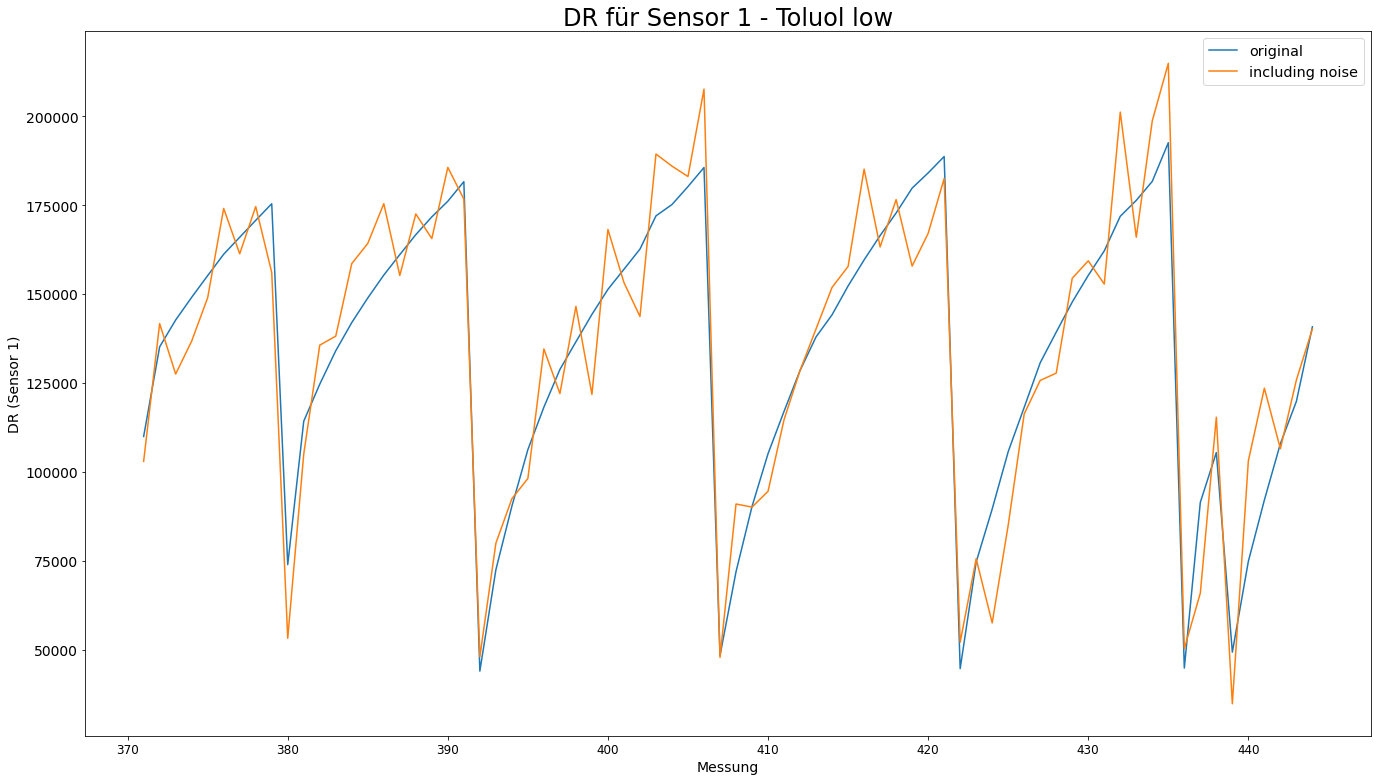

In [0]:
fig = plt.figure(figsize=(23.04,12.96))

plt.plot(df_original[df_original.target == 'Toluol low'].iloc[:,1], alpha=1, label='original')
plt.plot(df_modified[df_original.target == 'Toluol low'].iloc[:,1], alpha=1, label='including noise')

plt.title('DR für Sensor 1 - Toluol low', fontsize=24)
plt.xlabel('Messung')
plt.ylabel('DR (Sensor 1)')
plt.legend(loc='upper right', fontsize='x-large')

plt.savefig('noise.png', dpi=fig.dpi)

# Modul Daten

Dieses Jupyter Notebook soll einen Überblick über die Aufbereitung, Bereinigung und Visualisierung von Daten vermitteln. 

Für diesen Zweck wurde die Datenbank Gas Sensor Array Drift verwendet, heruntergeladen und vorher für diesen Zweck manipuliert (Gas- und Konzentrationsklassenlaben wurden zu einem Label zusammen geführt und dabei drei verschiedene Konzentrationsstufen definiert: low, medium und high). <br>
Der vollständige Datensatz kann auf <br>

http://archive.ics.uci.edu/ml/datasets/Gas+Sensor+Array+Drift+Dataset+at+Different+Concentrations

heruntergeladen werden. Außerdem werden verschiedene Informationen zu den Daten bereitgestellt. <br>

Der Datensatz enthält 13.910 Messungen von 16 chemischen Sensoren, welche abwechselnd sechs verschiedene Gase (Ethanol, Ethen, Ammoniak, Acetaldehyd, Aceton und Toluol) in verschiedenen Konzentrationen untersuchen. <br>
Der Datensatz wurde zwischen Januar 2008 und Februar 2011 (36 Monaten) erhoben. <br>
Jede Messung liefert anhand der 16 vorhandenen Sensoren eine 16-Kanal-Zeitreihe. <br>
Es werden zwei Hauptfeatures in diesem Datensatz betrachtet: <br>
$\rightarrow~$ (i) das stationäre Feature (steady-state) bezeichnet als `DR`, definiert als die maximale Widerstandsänderung in Bezug auf eine Basis, sowie die normalisierte Version davon (`|DR|`). <br>
$\rightarrow~$ (ii) ein Ansammlung an Features welche die Sensordynamik der gesamten Messung wiederspiegelt (`EMAi` und `EMAd` für verschiedene $\alpha$-Werte). <br>

Im folgendem Beispiel werden wir uns nur mit dem `DR` Feature auseinandersetzen. Da jeder der 16 Sensoren diesen Messwert liefert, sind auch 16 verschiedene Messwerte von `DR` vorhanden (`DR_1` des ersten Sensors, `DR_2`, des zweiten Sensorns und wo weiter). 

## Setup

In [0]:
import sys

# Notwendige Pakete können direkt über Jupyter installiert werden
#!{sys.executable} -m pip install package_name

# Handhabung von Vektoren und Matrizen
import numpy as np

# Vollständige Array-Asuagabe in Jupyter Notebook
np.set_printoptions(threshold=sys.maxsize)

# Auf lokale Verzeichnisse zuzugreifen
import os

# Hole aktuelles Arbeitsverzeihcnis
cwd = os.getcwd()

# Handhabung von Pfadnamen
import glob

# Für mathematische Formeln
import math

# Shapiro-Wilks Test, Kurvenfit, Faktor
from scipy import stats
from scipy.optimize import curve_fit
from scipy.special import factorial

# Ein Paket für die Datenanalyse
import pandas as pd

# Pandas Streumatrixdiagramm
from pandas.plotting import scatter_matrix

# Analysiere Pandas DataFrames
#import pandas_profiling as pp

# Verschiedene Scikit-Learn Pakete
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Um schöne Plots zu erhalten
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from matplotlib.patches import Rectangle

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=14)

# Für schöne Boxdiagramme (baut auf PyPlot's bxplt auf)
import seaborn as sns
pd.options.mode.chained_assignment = None

# 

# Bilder in Jupyter Notebook einfügen.
from IPython.display import Image

# Vergerben von In[] and Out[] auf der linken Seite jeder Zelle
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Laden des Pandas DataFrames

Als erstes müssen alle Beispieldatensätze geladen werden. Diese liegen in 10 verschiedene csv Dateien vor (batch0.csv bis batch9.csv). Anschließend werden diese zu einem gemeinsamen Datensatz zusammengeführt.

In [0]:
all_files_mod = glob.glob(cwd + r"/input/modified_df/*.csv")
all_files_original = glob.glob(cwd + r"/input/original_df/*.csv")

In [0]:
def get_dataset(files, limit=None):
    li = []
    
    if (limit):
        print("hello")

    for filename in files:
        #while(limit):
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    return pd.concat(li, axis=0, ignore_index=True)

In [0]:
df_modified = get_dataset(all_files_mod) 
df_original = get_dataset(all_files_original) 

## Ein kurzer Blick auf die Datenstruktur

Um ein Gefühl für die Datenstruktur zu erhalten bietet Pandas die folgenden Methoden an: <br>

`head(n)` $\longrightarrow~$ Gibt die $n$ ersten Zeilen (default $n$ = 5) aus. Nützlich um schnell zu testen, ob das Objekt im richtigen Datentyp vorliegt. <br>
`info()` $\longrightarrow~$ Gibt eine übersichtliche Zusammenfassung des DataFrames aus, einschließlich des Index dtypes, des Spalten dtypes, Nicht-Null-Werte sowie den Speicherverbrauch. <br>
`describe()` $\longrightarrow~$ Erstellt deskriptive Statistiken, welche die zentrale Tendenz, Verteilung und Form der Verteilung eines Datensatzes unter Ausschluss von NaN-Werten zusammenfasst. <br>
`value_count()` $\longrightarrow~$ Gibt die Anzahl eindeutiger Werte in absteigender Reihenfolge wieder. Muss an einem Feature aufgerufen werden.

Werfen wir als erstes ein Blick auf die `head()` Methode:

In [0]:
df_modified.head()

,target,DR_1,|DR|_1,EMAi0.001_1,EMAi0.01_1,EMAi0.1_1,EMAd0.001_1,EMAd0.01_1,EMAd0.1_1,DR_2,|DR|_2,EMAi0.001_2,EMAi0.01_2,EMAi0.1_2,EMAd0.001_2,EMAd0.01_2,EMAd0.1_2,DR_3,|DR|_3,EMAi0.001_3,EMAi0.01_3,EMAi0.1_3,EMAd0.001_3,EMAd0.01_3,EMAd0.1_3,DR_4,|DR|_4,EMAi0.001_4,EMAi0.01_4,EMAi0.1_4,EMAd0.001_4,EMAd0.01_4,EMAd0.1_4,DR_5,|DR|_5,EMAi0.001_5,EMAi0.01_5,EMAi0.1_5,EMAd0.001_5,EMAd0.01_5,...,DR_12,|DR|_12,EMAi0.001_12,EMAi0.01_12,EMAi0.1_12,EMAd0.001_12,EMAd0.01_12,EMAd0.1_12,DR_13,|DR|_13,EMAi0.001_13,EMAi0.01_13,EMAi0.1_13,EMAd0.001_13,EMAd0.01_13,EMAd0.1_13,DR_14,|DR|_14,EMAi0.001_14,EMAi0.01_14,EMAi0.1_14,EMAd0.001_14,EMAd0.01_14,EMAd0.1_14,DR_15,|DR|_15,EMAi0.001_15,EMAi0.01_15,EMAi0.1_15,EMAd0.001_15,EMAd0.01_15,EMAd0.1_15,DR_16,|DR|_16,EMAi0.001_16,EMAi0.01_16,EMAi0.1_16,EMAd0.001_16,EMAd0.01_16,EMAd0.1_16
0,Ethanol medium,69316.215650,6.095782,23.279670,36.308336,54.555254,-16.109512,-22.705971,-64.889185,57801.906322,6.390143,19.546376,30.073747,41.787411,-13.621149,-18.364309,-41.613884,16689.376324,4.250607,6.652512,17.050228,21.625769,-4.341562,-7.442641,-16.099412,16488.544399,3.770967,6.407007,15.568156,22.025745,-3.943828,-6.278376,-17.580022,3286.254076,2.727705,1.598719,4.358159,7.555038,-0.843797,-1.892033,...,15907.632473,3.882584,6.083221,14.066854,19.062035,-4.021262,-5.857554,-12.176161,6218.942955,3.196945,3.004556,9.992676,14.305895,-1.549591,-2.521906,-4.782140,6366.166781,3.357851,2.803022,9.516027,13.064757,-1.416725,-2.157258,-4.723547,25260.185552,5.237130,11.387373,31.548325,40.352214,-7.633304,-12.607173,-22.856610,23795.688232,4.705312,10.590404,27.657773,34.607236,-6.146351,-9.915252,-16.919653
1,Ethanol low,12488.244222,2.891813,8.967906,15.892093,23.067051,-2.887914,-10.541653,-16.331476,12088.036259,3.640209,6.813805,12.447471,20.664452,-1.549382,-4.954327,-11.340273,4873.433981,2.012153,4.078797,9.664201,16.543133,-0.879120,-1.323668,-7.826391,3460.138112,2.500929,3.941260,10.299725,14.675618,-1.003046,-1.710935,-7.116497,915.972550,1.575071,1.026605,3.468718,7.043320,-0.264331,-0.658795,...,3940.434097,2.146082,3.180007,9.765591,10.690288,-0.808264,-1.572049,-4.140994,1916.718373,1.877947,2.111817,7.857231,12.014142,-0.481389,-0.863710,-2.705014,2203.172868,1.907474,2.020371,7.245245,10.669647,-0.518904,-0.775732,-2.889248,6172.335564,2.400246,6.393626,19.028682,29.780863,-1.801422,-2.903909,-8.327977,5923.795836,2.264665,5.959326,16.389936,23.280657,-2.013252,-2.419278,-4.326538
2,Ethen medium,68310.342701,12.450358,19.092158,27.288582,42.240633,-12.716346,-51.141443,-122.199893,78295.684456,11.515997,19.416731,29.866898,40.697080,-12.410398,-18.811983,-62.671512,31058.637853,10.642692,11.836771,25.503148,32.036305,-6.410209,-9.791302,-30.453306,32407.184939,9.936442,12.618008,27.905998,32.191252,-6.752599,-10.374216,-23.852348,3264.834593,3.055377,1.146518,3.445906,6.143334,-0.750908,-1.289373,...,27944.117862,9.476143,9.925736,21.659777,25.598396,-5.408379,-8.193059,-18.202062,6268.741567,3.880294,2.490879,7.429503,11.620395,-1.231471,-2.249898,-4.411956,6532.295810,4.148317,2.476560,7.635612,10.641359,-1.424890,-2.193173,-4.950647,35337.124682,9.751603,15.299960,41.896946,50.507860,-7.888533,-12.603773,-28.707057,29623.637473,8.899965,12.784876,31.935898,41.340283,-6.406993,-10.949025,-24.330949
3,Ethen low,5833.604926,1.900410,1.953344,8.726820,20.815225,-0.629999,-1.321510,-7.127653,10825.316566,1.186540,0.321462,3.515634,12.242775,-0.433874,-2.143430,-6.300246,3453.508020,1.874434,1.110770,2.411993,6.952049,-0.643672,-0.810310,-8.766024,4038.636279,1.207115,0.902062,3.672886,6.898325,-0.187094,-1.478672,-7.273828,1028.614267,1.316401,0.191104,0.453812,3.564409,-0.104446,-0.488936,...,2153.643006,1.402371,1.570154,1.041181,1.918449,-0.599212,-0.611949,-4.231892,538.304071,1.245097,0.419097,0.752394,2.587870,-0.225348,-0.443968,-2.814342,775.943919,1.439648,0.362867,0.689794,2.629397,-0.120757,-0.471855,-2.745950,5271.830115,1.466628,2.733160,0.471614,10.268712,-1.517842,-1.722840,-2.414

Die erste Spalte verät uns das Klassenlabel. Die erste Instanz ist demnach eine Messung am Gas Ethanol bei niedriger Konzentration. Alle weitere Spalten beinhalten Daten die zu diesem Zeitpunkt bzw. Messpunkt erhoben worden sind. <br>

Rufen wir die `info()` Methode an den ersten fünf Spalten auf.

In [0]:
df_modified.iloc[:,:5].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13910 entries, 0 to 13909
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   target       13910 non-null  object 
 1   DR_1         13892 non-null  float64
 2   |DR|_1       13891 non-null  float64
 3   EMAi0.001_1  13896 non-null  float64
 4   EMAi0.01_1   13889 non-null  float64
dtypes: float64(4), object(1)
memory usage: 543.5+ KB


Für Pandas Indexing und Slicing siehe https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html. <br>

`info()` listet uns die verschiedene dtypes auf: vier float64 und eins vom Typ object. Anhand der unterschiedlichen Instanzen (total: 13910, DR_1: 13892, ...) erkennen wir, dass der Datensatz unvollständig ist (NaNs können ein Grund dafür sein). <br>

Werfen wir als nächstes ein Blick auf die `describe()` Methode.

In [0]:
df_modified.iloc[:,:5].describe()

,DR_1,|DR|_1,EMAi0.001_1,EMAi0.01_1
count,13892.000000,13891.000000,13896.000000,13889.000000
mean,50474.922772,6.637932,12.933379,18.732116
std,70169.739137,13.574723,17.682695,24.979475
min,-44367.015576,-13.079017,-6.720248,-12.007587
25%,7055.303280,2.265461,1.742918,2.613986
50%,20931.593737,3.965261,5.337442,7.825577
75%,63729.712642,8.659213,17.216590,25.954607
max,672655.354413,1341.209815,169.838832,228.306542


`describe()` bietet zusätzliche Informationen zu den jeweiligen Features. Dazu gehört die Anzahl, der Mittelwert (mean), die Standardabweichung (std) sowie das minimale, 25%, 50%, 75% und das maximale Quantil.

In [0]:
df_modified['target'].value_counts()

Aceton high           1834
Toluol low            1425
Ethen low             1190
Ammoniak high         1156
Ethanol low           1083
Ethen high            1082
Ethanol high           963
Acetaldehyd high       836
Ethen medium           654
Aceton low             642
Acetaldehyd low        565
Acetaldehyd medium     535
Aceton medium          533
Ethanol medium         519
Toluol medium          397
Ammoniak medium        311
Ammoniak low           174
Toluol high             11
Name: target, dtype: int64

Wir haben `value_counts()` an der `target` Spalte aufgerufen und sehen das Aceton medium mit 1924 Einträge über die meisten Messungen verfügt. Gefolgt von Toluol low und so weiter.

### Pandas Profiling

Im folgenden soll noch Pandas Profiling vorgestellt werden. Pandas Profiling bietet ähnlich wie die `describe()` Methode statistische Auswertungen. Mehr dazu kann auf https://github.com/pandas-profiling/pandas-profiling gelesen werden. <br>

Der folgende Code (auskommentiiert da dieser Schritt zeitintensiv ist) erstellt ein vollständigen Bericht und speichert diesen als `report.html` im lokalen Verzeichnis ab.

In [0]:
#profile = df_modified.profile_report(title='Pandas Profiling Report')
#profile.to_file(output_file="report.html")

## Split der Daten in Trainingsatz und Testsatz

Bevor wir die Daten nun visualiseren splitten wir diese in einem Trainings- und einen Testsatz. 
Es gibt viele Möglichkeiten die Daten in Trainings- und Testsätze aufzuteilen. Für Zeitreihen jedoch kann nicht jede beliebige Variante genommen werden. Ein kurze Visualisierung soll helfen die Wahl der richtigen Aufteilung zu treffen.

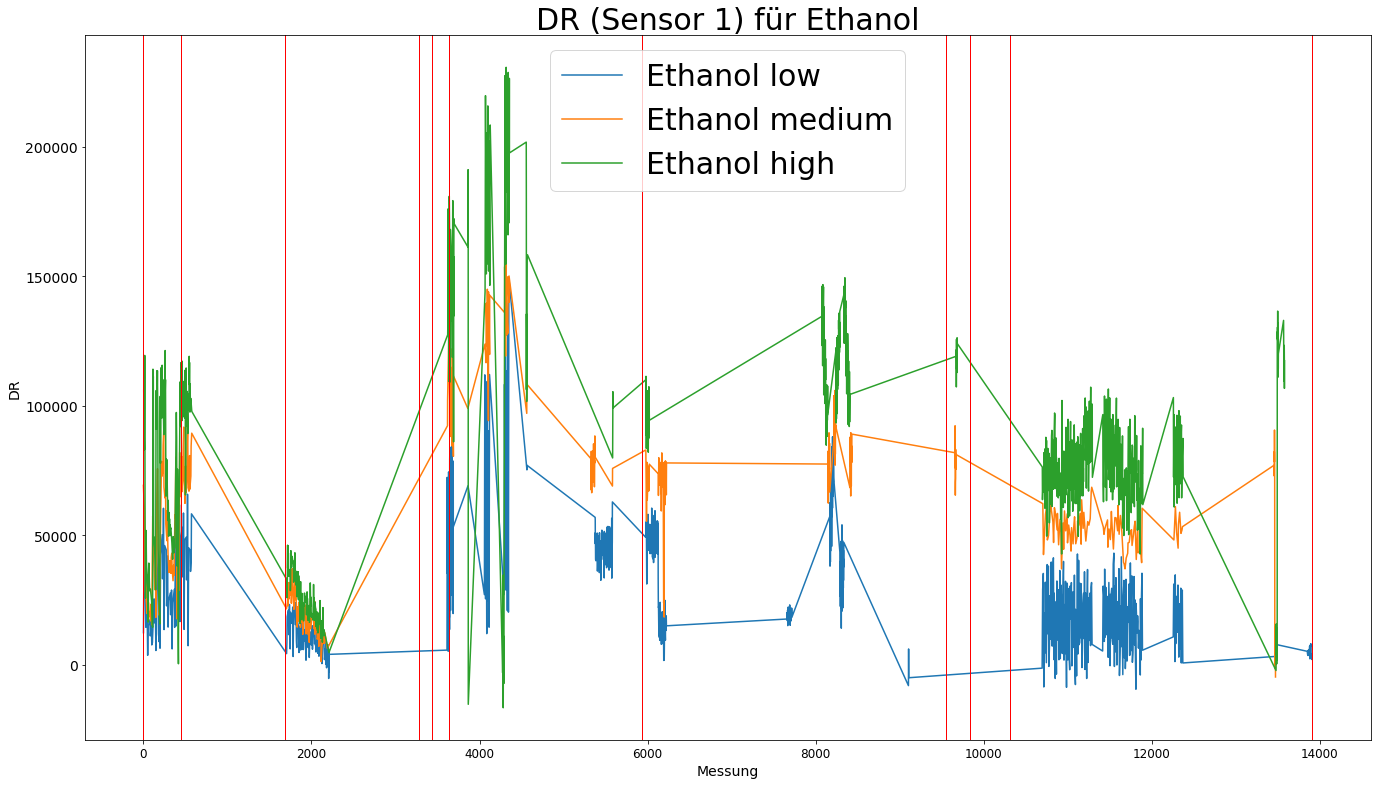

In [0]:
fig = plt.figure(figsize=(23.04,12.96))
plt.plot(df_modified[df_modified['target'] == 'Ethanol low'].iloc[:,1], alpha=1, label='Ethanol low')
plt.plot(df_modified[df_modified['target'] == 'Ethanol medium'].iloc[:,1], alpha=1, label='Ethanol medium')
plt.plot(df_modified[df_modified['target'] == 'Ethanol high'].iloc[:,1], alpha=1, label='Ethanol high')

plt.title('DR (Sensor 1) für Ethanol', fontsize=30)
plt.xlabel('Messung')
plt.ylabel('DR')

# Instanzen der batches aufsummiert
sum_time=[0, 445, 1689, 3275, 3436, 3633, 5933, 9546, 9840, 10310, 13910]

for batch in sum_time:
    plt.axvline(x=batch, linewidth=1, c='r')


plt.legend(loc='best', fontsize=30)
plt.show()

Der Plot zeigt den `DR` Messwert des ersten Sensors für Ethanol für alle drei Konzentrationsstufen (low, medium und high). Die roten Linien trennen die 10 Batches voneinander. Es ist zu erkennen, dass sich die Messwerte zwischen den verschiedenen Batches stark unterscheiden können (auch innerhalb der Batches). <br>

Die Aufteilung in ein Trainings- und Testsatz erfolgt gemäß einer Zeitreihe (eine Möglichkeit diese aufzuteilen ist 70:30 oder 80:20 (Training:Test) und hängt letztlich von den maximal verfügbaren Datenmengen ab). Die letzten beiden Batches (batch8.csv und batch9.csv) werden für das testen verwendet und von nun an beiseite gelegt.

In [0]:
df_training = get_dataset(all_files_mod[:8]) 
df_test = get_dataset(all_files_mod[8:]) 

In [0]:
df_training.shape, df_test.shape

((13455, 129), (455, 129))

Die verbliebene Trainingsdaten können dann zum Beispiel mit dem `GroupKFold` Kreuzvalidierungsmodell weiter in einen Trainings- und Validierungssatz aufgeteilt werden. Weitere Möglichkeiten zur Aufteilung kann auf der Homepage von SciKit-Learn nachgelesen werden https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py. <br>

Als nächstes werden die Trainingsdaten von Ausreißern, fehlenden Werten sowie vom Rauschen bereinigt.

## Daten Bereinigen und Transformieren

In diesem Abschnitt soll eine sehr elegante Methode zur Bereinigung und Transformation der Daten vorgestellt werden. <br>
Da hier eine Sequenz an verschiedenen Transformationen durchgeführt werden soll, bietet sich die Anwendung von SciKit-Learn's Pipeline an. <br>


#### NaNs
Für den Umgang mit NaNs gibt es einige Möglichkeiten: <br>
$\rightarrow~$ Entfernen der jeweiligen Instanzen (Pandas `dropna()`). <br>
$\rightarrow~$ Entfernen des ganzen Features (Pandas `drop()`). <br>
$\rightarrow~$ Ersetzen durch einen bestimmten Wert (Null, den Median, den Mittelwert mittels Pandas `fillna()` oder Scikit-Learns SimpleImputer Transformer)<br>
Im folgenden Beispiel werden wir NaNs durch den Median ersetzen. <br>

#### Ausreißer
Um Ausreißer zu detektieren kann die $\sigma$-Regel verwendet werden. Dabei wird der sogenannte Z-Score für jeden Datenpunkt berechnet (die Entfernung eines Datenpunktes zum Mittelwert ausgedrückt in Standardabweichungen) und falls der Betrag des Z-Scores einen Grenzwert überschreitet (z.B. drei, heißt drei Standardabweichungen von Mittelwert entfernt) kann dieser Datenpunkt als Ausreißer betrachtet werden. <br>
Eine andere Möglichkeit wäre einfach ein gültigen Wertebereich von Hand zu definieren: [$x_{\text{min}},x_{\text{max}}$] und alle Werte außerhalb des Gültigkeitsbereichs als Aureißer zu betrachten. <br>
Sind Ausreißer erkannt worden, können diese genau wie NaNs behandelt werden. Ausreißer werden in diesem Beispiel durch den Median ersetzt. <br>


#### Rauschen
Anschließend soll kurz auf die Behandlung von Rauschen eingegangen werden. Rauschen kann bereits Hardwareseitig durch Frequenzfilter (z.B. diskrete Lineare Filter wie den Butterworth-Filter oder den exponentielle Filter) entfernt werden. Aber auch Softwareseitig werden verschiedene Filtermethoden angeboten. In der Regel werden bei der Anwendung solcher Filter auf Zeitreihen alle Daten verändert. Ein Beispiel ist der gleitenden Mittelwert oder der gleitenden Median. Letzteres soll hier vorgestellt werden, da Pandas diesen bereits mitbringt. <br>

An dieser Stelle möchte ich erwähnen das die Behandlung von Rauschen hier nur zu demonstrationszwecken gezeigt werden soll. In einem Realfall wäre der Einsatz für diesen Datensatz mehr als fraglich, da der gleitende Mittelwert hier über verschiede Batches, verschiedene Gase und verschiedene Konzentrationsstufen hinaus berechnet wird, was offensichtlich nicht sinnvoll ist. <br>


#### Normalisierung und Skalierung
Im letzten Schritt der Datenbereinigung werden wir die Daten skalieren. Verschiedene Features im Datensatz können Werte in verschiedenen Bereichen aufweisen. So kann beispielsweise in einem Mitarbeiterdatensatz der Gehaltsbereich von Tausend bis Hunderttausend liegen, der Wertebereich des Altersmerkmals aber nur zwischen 20-60. Das heißt, eine Feature ist im Vergleich zum anderen stärker gewichtet. Anwendungen statistischer Methoden können in solchen Situationen unerwünschte und unbrauchbare Ergebnisse liefern. Anwendungen bei denen eine Featureskalierung wichtig ist sind <br>
$\rightarrow~$ k-nearest neighbors oder k-means mit euklidischem Abstandsmaß; <br>
$\rightarrow~$ Logistische Regression, SVM, Perzeptrons oder neuronale Netze bei denen Gradient Descent verwendet wird; <br>
$\rightarrow~$ lineare Diskriminanzanalyse, Hauptkomponentenanalyse oder Kernel-Hauptkomponentenanalyse. <br>

Um das zu vermeiden empfiehlt es sich die Daten zu transformieren. Gängige Transformationen sind <br>

$\rightarrow~$ Standardisierung: skalieren der Daten auf die Normalverteilung $\mathcal{N}(0,1)$; <br>
$\rightarrow~$ Min/Max-Normalisierung: skalieren der Daten auf ein fixen Bereich, z.B. [0,1]; <br> 
$\rightarrow~$ $\mathcal{l}_{1}$-/$\mathcal{l}_{2}$-Normalisierung: Normalisierung des Featurevektors auf den Einheitsvektor (bei der $\mathcal{l}_{1}$-Normalisierung summiert sich der Absolutwert jedes Elements auf 1 und bei der $\mathcal{l}_{2}$-Normalisierung summiert sich die Quadratsumme zu 1).

Welche letztlich die beste Wahl ist hängt stets von der Situation ab.

### Pipelines

Das hier gezeigt Vorgehen versteift sich auf die Anwendung von Pipelines (siehe Backup der Modul Daten Präsentation). <br>
Diese können eine Sequenz von Transformationen (sogenannte Transformatoren) abarbeiten. Zudem können schnell und einfach eigene Transformatoren geschrieben werden, wie hier gezeigt für den `RollingMean`, die `OutlierDetection` und den `GasLabel` Transformer. <br>

Das implementieren eines eigenen Transformers soll am Beispiel `RollingMean` kurz beschrieben werden. Als erstes wird eine Klasse mit dem Namen RollingMean definiert, welche von den Basisklassen BaseEstimator und TransformerMixin erbt. Die `fit()` Methode gibt einfach self zurück und lediglich die `transform()` Methode wird der Anforderung nach angepasst. Hier wird eine DataFrame Objekt zurückgegeben welche den asymmetrischen gleitenden Mittelwert enthält.

In [0]:
class RollingMean(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=3):
        self._window = window_size
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df_temp = pd.DataFrame(X)
        return df_temp.rolling(window=3, min_periods=1).mean().to_numpy()

In [0]:
class OutlierDetection(BaseEstimator, TransformerMixin):
    def __init__(self, std):
        self._std = std
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        mask = np.abs((X - X.mean(0)) / X.std(0)) > 3
        return np.where(mask, np.median(X, axis=0), X)

In [0]:
# Sorter: Fügt eine Spalte am Ende von X  mit numerischen Werten für die Gase hinzu unabhängig Ihrer Konzentration hinzu 
class GasLabel(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        arr = np.zeros(shape=(X.shape[0],1)) 
        for gas in range(6):
            for concentration in range(3):
                arr[X[:,gas * 3 + concentration] == 1] = gas + 1
        return np.c_[X, arr]

Als erstes sollte berücksichtigt werden, dass numerische Features anders als (textbasierte) kategorische Features oder Klassenlabels tranformieren. Wir trennen daher die Klassenlabels von den restlichen Daten, Prädiktoren genannt. Die Prädiktoren können je nach Typ, numerisch oder textbasiert, weiter getrennt werden. In unserem Beispiel sind die Prädiktoren numerisch. Wir trennen also lediglich die Klassenlabels von den Prädikatoren und transformieren beide getrennt voneinander durch unterschiedliche Transformatoren und Pipelines. <br>

Wir definieren uns eine Liste mit Prädiktoren die transformiert werden sollen. Alle anderen werden nicht weiter berücksichtigt. Wir bezeichnen diese Liste als num_features und tragen dabei die Namen der Features ein, hier die `DR` Messungen der ersten vier Sensoren. Da wir auch die Klassenlabels transofmieren möchten erstellen wir für diese ebenfallls eine Liste.

In [0]:
num_features = ['DR_1', 'DR_2', 'DR_3', 'DR_4']
target = ['target']

#### Transformationen der numerischen Features

Anschließend definieren wir die Pipeline der numerischen Transformationen als Liste. Diese erhält den Namen des Transformers (beliebig) sowie den Transformer. Dies legt auch die Reihenfolge der durchzuführenden transformationen fest.

In [0]:
num_pipeline = Pipeline([
    ('mean_imputer', SimpleImputer(strategy='median')),
    ('outlier_detection', OutlierDetection(std=3)),
    ('rolling_mean', RollingMean(3)),
    ('scaler', MinMaxScaler(feature_range=(0,1))),
])

$\rightarrow~$ SimpleImputer: ersetzt NaNs durch den Median. <br>
$\rightarrow~$ OutlierDetection: detektiert Ausreißer nach der 3-$\sigma$ Regel und ersetzt diese durch den jeweiligen Median des Features. Die Implementierung ist oben gezeigt. <br>
$\rightarrow~$ RollingMean: behandelt Daten mit rauschen mit dem gleitenden Median und einer Fenstergröße von drei Werten. <br>
$\rightarrow~$ MinMaxScaler: Skaliert uns die Daten auf ein gewünschtes Intervall, hier auf das Intervall [0,1].

#### Transformationen der Klassenlabels

Erstellen wir noch eine Pipeline, welche die transformationen der Klassenlabels festlegt.

In [0]:
target_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder(sparse=False, categories='auto')),
    ('sorter', GasLabel()),
])

$\rightarrow~$ SimpleImputer: ersetzen fehlender Werte durch den meist auftretenden Wert (äquivalent zur Mode, andere statistische Maße die genutzt werden können sind Mean oder Median). Der SimpleImputer soll hier nur zu Präsentationszwecken gezeigt werden, da keine Klassenlabels im vorliegenden Beispieldatensatz fehlen. <br>
$\rightarrow~$ OneHotEncoder: überführt textbasierte kategorische Daten zunächst in numerische Kategorien und One-Hot encoded diese anschließend. Das heißt, es werden $n$ binäre Spaltenvektoren ($n$ Anzahl der verschiedenen Klassenlabels, hier 18) erzeugt. Das One-Hot encoding macht Sinn, da die meisten Algorithmen des Machine-Learnings den Umgang mit Zahlen bevorzugen. <br>
$\rightarrow~$ Zuletzt habe ich den `GasLabel` Transformer implementiert. Dieser fügt am Ende eine weitere Spalte hinzu und ist vom Prinzip her das selbe wie Scikit-Learns `LabelEncoder` (dieser funktioniert im aktuellen Release nicht mit dem ColumnTransformer den wir später verwenden werden). Dabei wird jeder Kategorie eine Zahl zugeordned, aufsteigend und beginnend mit eins. Dies wird uns später bei der Datenvisualisierung helfen.

#### ColumnTransformer

Sind beide Pipelines definiert, führen wir diese mit dem `ColumnTransfromer` zusammen und geben für jede Pipelinde noch die zu transformierende Liste mit. <br>

Achtung: vielleicht haben Sie schon gemerkt, dass bei den von uns geschriebenen Transformatoren im Konstruktor Parameter entgegen genommen werden (z.B. RollingMedian: `self._window = window_size`), diese aber in der `fit()` Methode nicht verwendet werden. Wir würden an dieser Stelle ein Fehler erhalten. Dieses Problem bringt aktuell der `ColumnTransformer` mit und wird hoffentlich im kommenden Release behoben.

In [0]:
full_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('target', target_pipeline, target)],
    remainder='drop')

Transformieren wir die Trainungs- und Testdaten. Beachte, wir erhalten kein Pandas DataFrame Objekt als Rückgabewert sondern NumPy Arrays.

In [0]:
np_train_prepared = full_pipeline.fit_transform(df_training)
np_test_prepared = full_pipeline.transform(df_test)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Überprüfen wir ob die Dimensionen stimmen und ob noch NaNs vorhanden sind.

In [0]:
np_train_prepared.shape, np_test_prepared.shape

((13455, 23), (455, 23))

In [0]:
np.isnan(np.min(np_train_prepared)), np.isnan(np.min(np_test_prepared))

(False, False)

Untersuchen wir die ersten zwei Zeilen der transformierten Trainingsdaten.

In [0]:
np_train_prepared[:2]

array([[0.30449407, 0.26041308, 0.35073046, 0.34350204, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 4.        ],
       [0.19967556, 0.17101734, 0.23469094, 0.21513364, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 4.        ]])

In [0]:
full_pipeline.transformers_[1][1].steps[1][1].get_feature_names()[10] #16 toluol low

'x0_Ethanol low'

Sollte eine fortgeschrittene Feature Selection Teil der Pipeline sein, kann auf https://scikit-learn.org/stable/modules/feature_selection.html mehr dazu gelesen werden.

In [0]:
df_training.shape, df_original.shape

((13455, 129), (13910, 129))

## Speichern der bereinigten Daten

Speichern wir Daten im csv und pickle Format ab:

In [0]:
csv_output_dir = cwd + "/output/csv/"
pickle_output_dir = cwd + "/output/pickle/"

if not os.path.exists(csv_output_dir):
    os.makedirs(csv_output_dir)
    
if not os.path.exists(pickle_output_dir):
    os.makedirs(pickle_output_dir)

In [0]:
pd.DataFrame(np_train_prepared).to_csv(csv_output_dir + "cleaned_train_data.csv", header=True, index=None)
pd.DataFrame(np_test_prepared).to_csv(csv_output_dir + "cleaned_test_data.csv", header=True, index=None)

pd.DataFrame(np_train_prepared).to_pickle(pickle_output_dir + "cleaned_train_data.pkl")
pd.DataFrame(np_test_prepared).to_pickle(pickle_output_dir + "cleaned_test_data.pkl")

Nach dem bereinigen, transformieren und speichern der Daten, widmen wir uns als nächstes verschiedene Möglichkeiten der Datenvisualisierung.

## Visualisierung der Daten

Einer der ersten und wichtigsten Schritte der Datenanalyse ist die Daten zu visualisieren (genannt plotten), um ein tieferes Verständnis für die Daten zu erlangen. Insbesondere können Zusammenhänge verschiedener Features erkannt werden. <br>

In Zeitreihenplots sollten wir immer nach Ausreißern, saisonalen Mustern, allgemeinen Trends und anderen interessanten Merkmalen suchen. An dieser Stelle sollten jedoch hoffentlich bereits alle Ausreißer entfernt worden sein. Wir werden sehen.

Definieren wir uns noch ein paar Namen für eine übersichtlichere Visualisierung.

In [0]:
n_gas = 6

gas_names = ['Acetaldyh', 'Aceton', 'Ammoniak', 'Ethanol', 'Ethen', 'Toluol']
labels = ['low', 'medium', 'high']

Fassen wir die sechs verschiedene Gase Zwecks zusammen.

In [0]:
X_gas = []

for i in range(n_gas):
    a1 = np_train_prepared[np_train_prepared[:,22] == int(i+1)][:,0:4] # DR Messerwerte
    a2 = np_train_prepared[np_train_prepared[:,22] == int(i+1)][:,22] # Textlabel
    a3 = np_train_prepared[np_train_prepared[:,22] == int(i+1)][:,i*3+4:i*3+7] * (i+1) # Zugehörige OneHot-Vektoren
    X_gas.append(np.c_[np.c_[a2,np.roll(a3,+0,axis=1)],a1])

In [0]:
X_gas[0][:1]

array([[1.        , 0.        , 0.        , 1.        , 0.22100824,
        0.17321241, 0.47413693, 0.4776462 ]])

Die erste Zeile ist nun wie folgt aufgebaut: die erste Zahl gibt Auskunft über welches Gas es sich handelt (dies ist der Output der GasLabel Transformation. Die Zahl 1 sagt uns, dass es sich bei dem Gas um Acetaldehyd handelt. Die Gase sind jetzt neu sortiert was für die Visualisierung kein Problem darstellt). Die folgenden drei Spalten gehören dem zugehörigen One-Hot-Vektor (low, medium und high) und die letzten vier Zahlen sind den jeweiligen `DR` Messwerten zuzuordnen.

### Histogramme

Histogramme spielen eine grundlegende Rolle in jeder Art von Datenanalyse. Histogramme geben Aufschluss über die tatsächliche statistische Verteilung der Features (z.B. gleichverteilt, gaußverteilt, poissonverteilt oder skalenfrei verteilt). Dabei können einzelne Features eindimensional dargestellt werden oder in zweidimensionalen Histogrammen miteinander verglichen werden. <br>

Es werden $n$ Histogramm-Intervalle, genannt Bins, definiert und dabei zählen wir, wie viel Werte der Stichprobensammlung in das jeweilige Intervall fallen. Diese liefern dann die jeweiligen Häufigkeiten in den Bins, dargestellt durch Balken. <br>

Entscheidend dabei ist die Wahl der richtigen Intervallbreite (Binbreite). Zu wenig oder zu viel Bins lässt die Form der Verteilung oftmals nicht erkennen. Betrachten wir daher eine Verteilung mit verschiedenen Binbreiten.

#### Die Wahl der richtigen Binbreite

<Figure size 432x288 with 0 Axes>

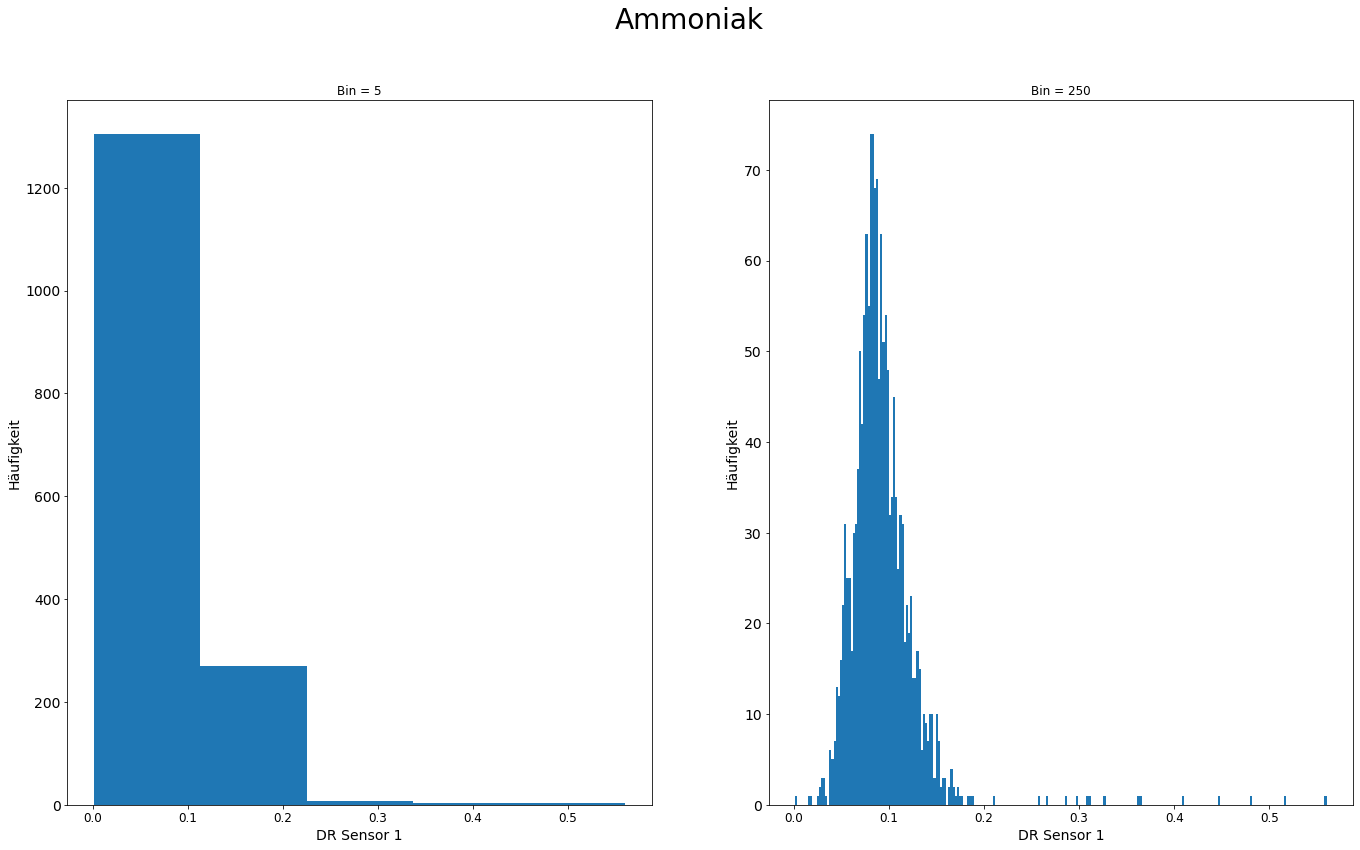

In [0]:
plt.clf()

fig = plt.figure(figsize=(23.04,12.96))
plt.subplots_adjust(hspace=0.35)

plt.subplot(1,2,1)
plt.hist(X_gas[2][:,4], bins = 5)
plt.xlabel('DR Sensor 1')
plt.title('Bin = 5')
plt.ylabel('Häufigkeit')

plt.subplot(1,2,2)
plt.hist(X_gas[2][:,4], bins = 250)
plt.xlabel('DR Sensor 1')
plt.title('Bin = 250')
plt.ylabel('Häufigkeit')

plt.suptitle('Ammoniak', fontsize=28)

plt.show()

Das Histogramm zur linken offenbart nicht die poissonähnliche Verteilung und erinnert eher an eine Exponentialverteilung. Das Histogram zur rechten zeigt dies schon eher (Achtung: die Poisson-Verteilung ist eine diskrete Wahrscheinslichkeitsverteilung. Um beispielsweise eine Kurve zu fitten sollte man sich vielleicht eher die Beta- oder die Gammafunktion anschauen). Jedoch, würde eine bessere Wahl der Binbreite ein eindeutigeres Ergebnis zeigen. <br>

Dazu sollen nun drei verschiedene Methoden zur Ermittlung der Binanzahl $h$ bzw. der Binbreite $h_n$ vorgestellt werden: <br>

$\rightarrow ~$ Anhand der Anzahl der Daten $n$:
$$h = 1+\log_{2}n$$
$\rightarrow ~$ Mittels Gauß-Verteilung mit Standardabweichung $s$:
$$h_n = \frac{3.49\cdot s}{\sqrt[3]{n}}$$
$\rightarrow ~$ Mittels Quantilen (gut geeignet für Long-Tail-Verteilungen):
$$h_n = \frac{2\cdot(\mathcal{Q}_{75\%}-\mathcal{Q}_{25\%})}{\sqrt[3]{n}}$$

Schauen wir uns das Histogramm vom obigen Beispiel mit diesen drei verschiedenen Methoden zur Binanzahl an sowie einem dynamischen Binning (hier kann/muss der Parameter `density=True` gesetzt werden, um die Bins zu normalisieren).

<Figure size 432x288 with 0 Axes>

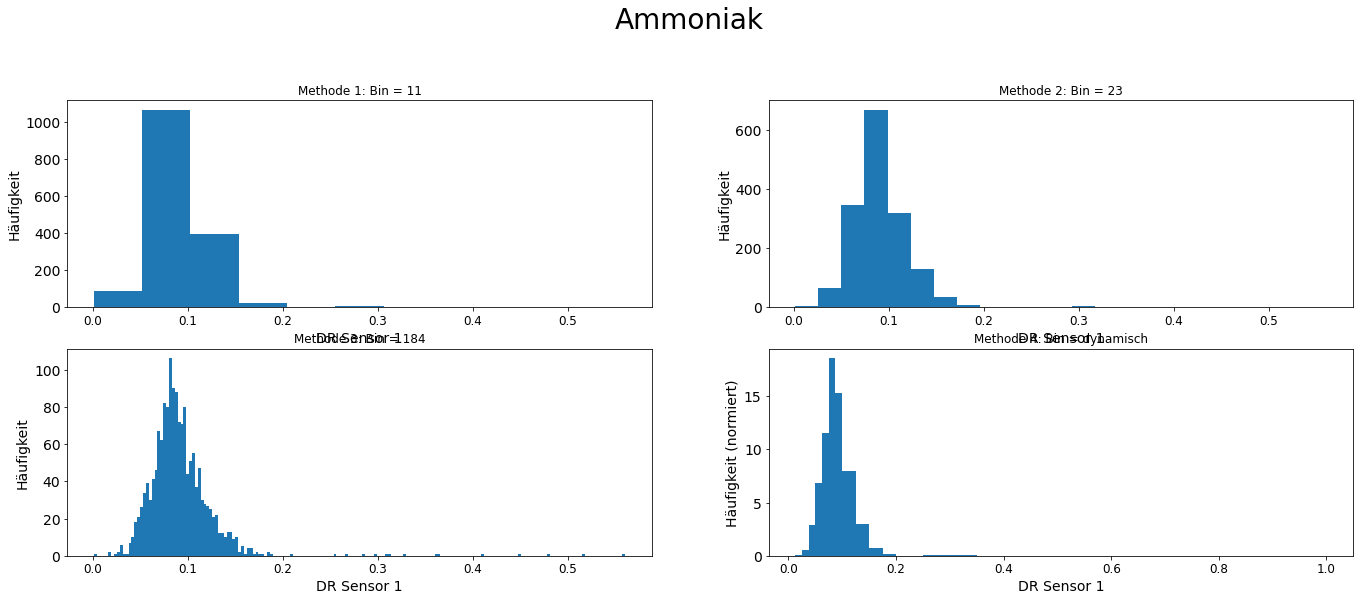

In [0]:
def methode1(n):
    m = 1+ math.log2(n)
    return int(m)

def methode2(n, sigma):
    m = (3.49 * sigma) / math.pow(n,1./3)
    return float(m)

def methode3(n, q_25, q_75):
    m = (2 * (q_75 - q_25)) / math.pow(n,1./3)
    return float(m)

anzahl = X_gas[2].shape[0]
std = X_gas[2][:,4].std()
std2 = (X_gas[2][:,4].max() - X_gas[2][:,4].min()) / 4.
Q25 = np.percentile(X_gas[2][:,4], 25)
Q75 = np.percentile(X_gas[2][:,4], 75)

plt.clf()
fig = plt.figure(figsize=(23.04,12.96))

plt.subplot(3,2,1)
bins = methode1(anzahl)
plt.hist(X_gas[2][:,4], bins = bins)
plt.xlabel('DR Sensor 1')
plt.ylabel('Häufigkeit')
plt.title('Methode 1: Bin = {}'.format(bins))

plt.subplot(3,2,2)
bins = methode2(anzahl, std2)
plt.hist(X_gas[2][:,4], bins = int(1 / bins))
plt.xlabel('DR Sensor 1')
plt.ylabel('Häufigkeit')
plt.title('Methode 2: Bin = {}'.format(int(1 / bins)))

plt.subplot(3,2,3)
bins = methode3(anzahl, Q25, Q75)
plt.hist(X_gas[2][:,4], bins = int(1 / bins))
plt.xlabel('DR Sensor 1')
plt.ylabel('Häufigkeit')
plt.title('Methode 3: Bin = {}'.format(int(1 / bins)))

plt.subplot(3,2,4)
bins = [0.0125, 0.025, 0.0375,  0.05, 0.0625, 0.0750, 0.0875,  0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.8, 1.0]
plt.hist(X_gas[2][:,4], bins = bins, density=True)
plt.xlabel('DR Sensor 1')
plt.ylabel('Häufigkeit (normiert)')
plt.title('Methode 4: Bin = {}'.format('dynamisch'))

plt.suptitle('Ammoniak', fontsize=28)
plt.show()

Die erste Methode scheint offensichtlich in diesem Beispiel keine geeignete Wahl zu sein, da diese sogar eine Gauß-Verteilung zeigen könnte. Handelt es sich um eine multimodale Verteilung geht diese Information bei der ersten, der zweiten sowie bei der vierten Methode verloren. Hier wäre die dritte Methode sicherlich die beste Wahl (wobei auch eine Binanzahl von 100 sicherlich genügen würde). Handelt es sich jedoch nicht um eine multimodale Verteilung ist die zweite und vierte Methode die beste Wahl.

### Eindimensionale Histogramme

Visualisieren wir als erstes die verschiedene Konzentrationswerte der sechs Gase:

<Figure size 432x288 with 0 Axes>

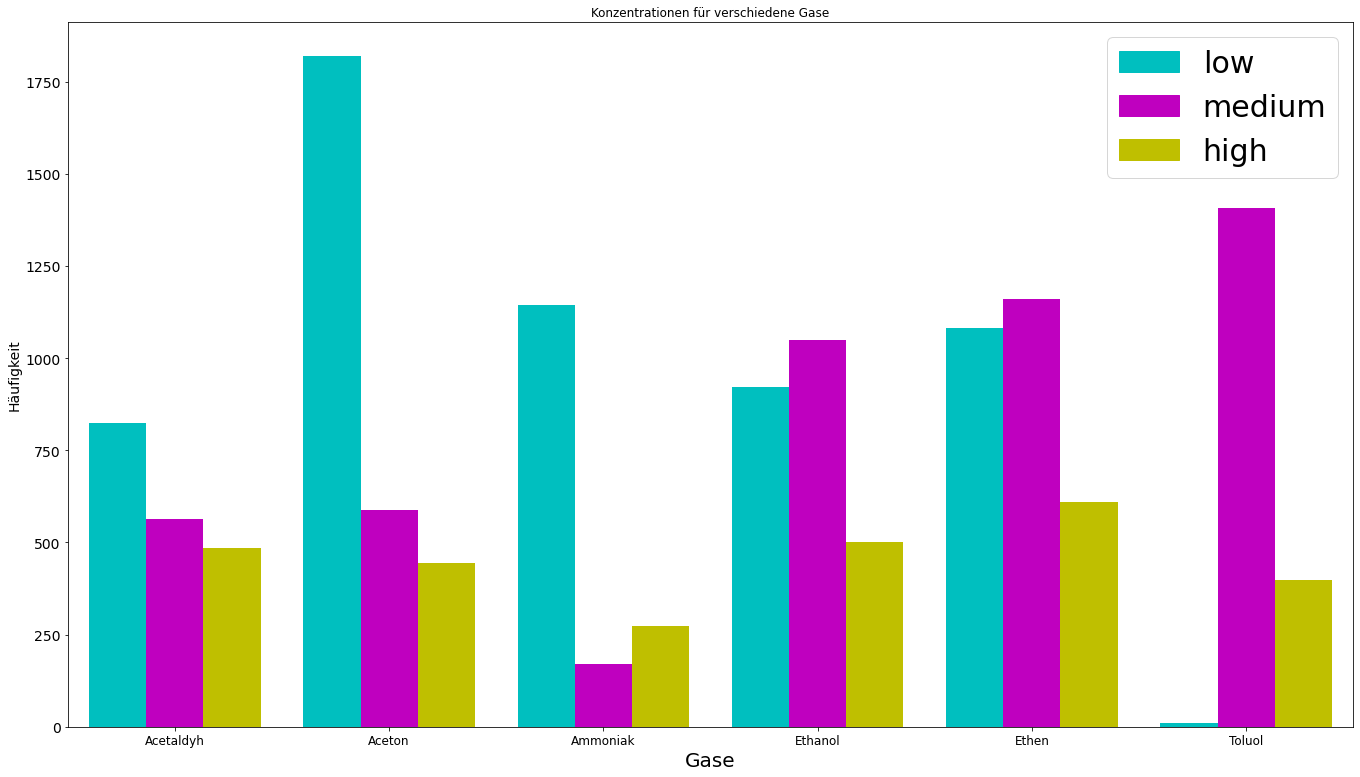

In [0]:
plt.clf()
fig = plt.figure(figsize=(23.04,12.96))

bins = np.arange(len(gas_names)+1) + 0.5

color = ['c', 'm', 'y']

for gas in range(n_gas):
    data = []
    for concentration in range(3):
        data.append(X_gas[gas][:,0][X_gas[gas][:,concentration+1] == gas+1])
    plt.hist(data, bins='auto', color=color, label=labels)


handles = [Rectangle((0,0),1,1,color=c) for c in color]
labels= ['low','medium', 'high']
plt.legend(handles, labels, fontsize=30)

plt.title("Konzentrationen für verschiedene Gase")
plt.xlabel("Gase", fontsize=20)
plt.ylabel('Häufigkeit')
plt.xticks(bins+0.5, gas_names)
plt.xlim([0.5,6.5])

plt.show()

Dieses Histogramm zeigt die sechs verschiedenen Gase und ihre Konzentrationen. Für die ersten drei Gase wurden am häufigsten Messungen an niedriger Konzentration durchgeführt. Für die letzten drei Gase an einer mittleren Konzentration. Auffällig ist das Toluol sehr wenig Messungen an niedriger Gaskonzentrationen besitzt und Aceton dagegen die meisten.

Werfen wir ein Blick auf die `DR` Messwerte des ersten Sensors für alle sechs Gase. Dies ermöglicht uns eventuell die zugrundeliegende Verteilung zu erkennen.

<Figure size 432x288 with 0 Axes>

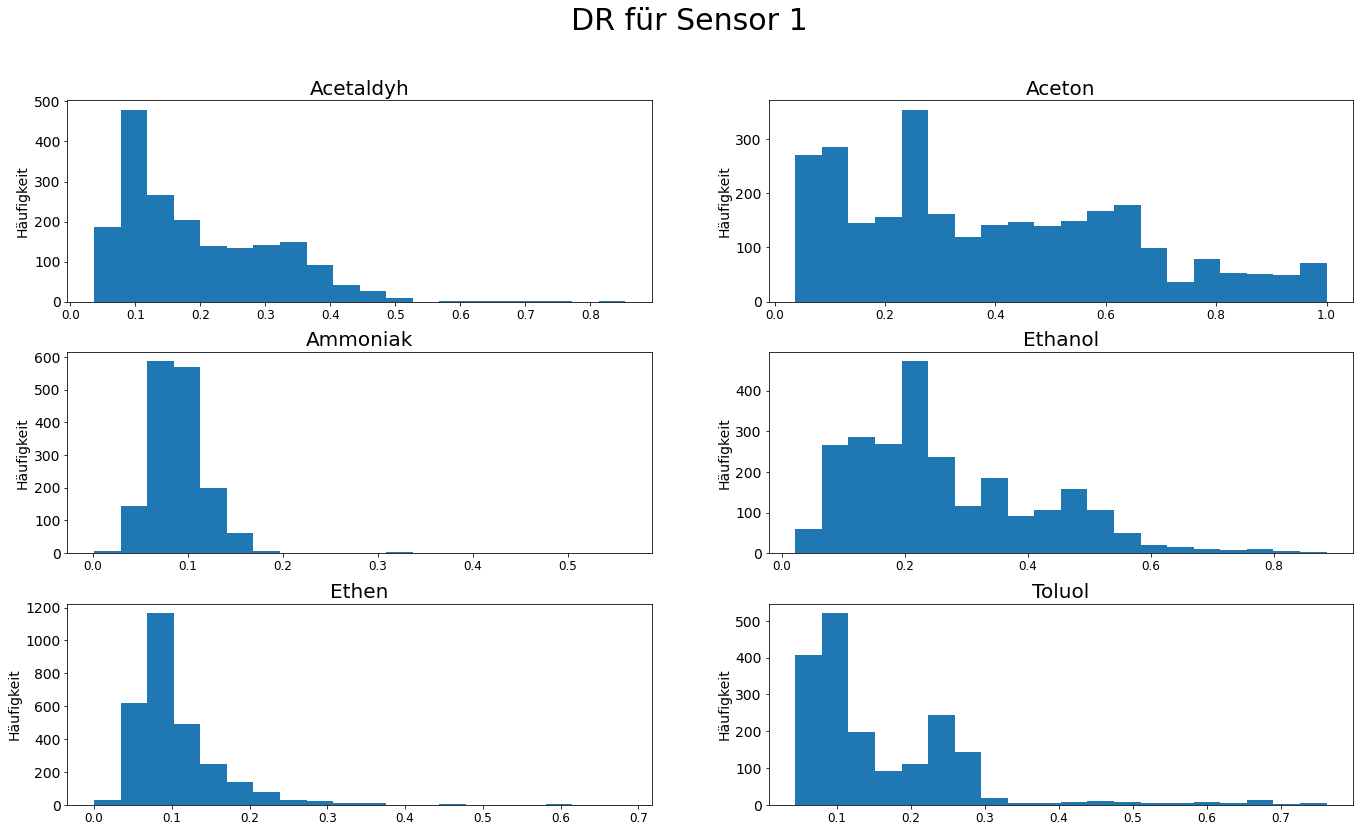

In [0]:
plt.clf()

fig = plt.figure(figsize=(23.04,12.96))
plt.subplots_adjust(hspace=0.25)

for gas in range(n_gas):
    plt.subplot(3,2,gas+1)
    plt.hist(X_gas[gas][:,4], bins=20)
    plt.title(gas_names[gas],fontsize=20)
    plt.ylabel('Häufigkeit')
plt.suptitle("DR für Sensor 1", fontsize=30)

plt.show()

Einige der gezeigten Verteilungen zeigen ein rechtsschiefes Verhalten. Die Spitzen der Verteilungen liegen meist um 0,1. Grund für eine verschobenen Spitze kann ein schlechtes Binning oder ein zu kleiner Stichprobenumfang sein. Letzteres kann auch der Grund sein für die merkwürde Verteilung von Ethanol und Toluol. Da wir aber mehrere verschiedene Kontentrationen der Gase betrachten ist die Verteilung jedoch eher ein Hinweis auf eine multimodale Verteilung.

#### Schiefsymmetrische Verteilungen

An dieser Stelle soll nochmal die Wichtigkeit und der Umgang mit schiefsymmetrischen Daten angesprochen werden, da die Transformation schiefsymmetrischer Daten ein wichtiger Schritt der Datenbereinigung darstellt. Schiefe ist ein Maß welche die Abweichung einer Verteilung zur Normalverteilung beschreibt. Einige Machine Learning Algorithmen (z.B. 
Logistic Regression) führen zu verzerrten Ergebnissen wenn diese mit schiefsymmetrischen Daten gefüttert werden. Die Python Library Scipy verfügt über den Shapiro-Wilks Test um die Schiefe einer Variable festzutellen. <br>

Statistische Tests wie der Shapiro-Wilks Test liefern zwei Größen: Die Teststatistik (hier die W-Statistik) und den P-Wert zur schnellen Interpretation des Tests. Wir betrachten daher nur den P-Wert. Die Nullhypothese für diesen Test ist so festgelegt, dass die Daten einer Probe aus einer Normalverteilung stammen. Ist der P-Wert kleiner als 0,05 besitzen die Daten eine signifikante Schiefe.

In [0]:
stats.shapiro(X_gas[4][:,4])

(0.802281379699707, 0.0)

Der P-Wert ist hier 0 und demnach handelt es sich bei Ethen bei dem `DR` Messwert des ersten Sensors um schiefe Daten. <br>

Eine bequemere Möglichkeit die Schiefe von Daten festzustellen, ist die Verwendung der `skew()` Methode die Pandas mitbringt. Diese berechnet den Fisher-Pearson standardisierten Momentkoeffizienten für alle Spalten des DataFrames.

In [0]:
pd.DataFrame(X_gas[4]).skew(axis=0)

0    0.000000
1    0.497995
2    0.380538
3    1.394261
4    2.551504
5    1.385405
6    0.767767
7    0.782505
dtype: float64

Die Ausgabe liefert für jede Spalte einen Wert. Die Zahl 4 entspricht also den `DR` Messwert des ersten und die Zahl sieben des vierten Sensors. Alle Werte sind größer Null und demnach rechtsschief (negative Werte entsprechen linkschiefe Daten und die Zahl Null symmetrisch verteilter Daten). Der Absolutwert des Koeffizienten ist ein Maß für die Stärke der Schiefe. Die Daten des ersten Sensors sind demzufolge am schiefsten verteilt.

Im folgenden werden vier gängige Transformationen vorgestellt um Daten symmetrisch wie möglich darzustellen. Bei der ersten Transformation handelt es sich um die Quadratwurzelt ($\sqrt{X}$), bei der zweiten um den Logarithmus ($\log(X)$), bei der dritten um den Kehrwert ($\frac{1}{X}$) und bei der letzten um die Box-Cox Transformation. <br>

Das Beispiel wird ebenfalls wieder für Ethen gezeigt. Für die Transformation verwerfen wir alle Null-Einträge. Eine Alternative hierzu wäre die Addition eines infinitesimalen Wertes (z.B. `np.finfo(float).eps`). Sämtliche Transformationen werden im Anschluss für den Vergleich auf das Intervall von Null bis Eins skaliert.

In [0]:
def MinMaxTrafo(arr):
    return np.interp(arr, (arr.min(axis=0), arr.max(axis=0)), (0,+1))

original = X_gas[4][:,4][X_gas[4][:,4] != 0]
square = MinMaxTrafo(np.sqrt(original))
rezi = MinMaxTrafo(np.reciprocal(original))
log = MinMaxTrafo(np.log(original))
boxcox = MinMaxTrafo(stats.boxcox(original)[0])

<Figure size 432x288 with 0 Axes>

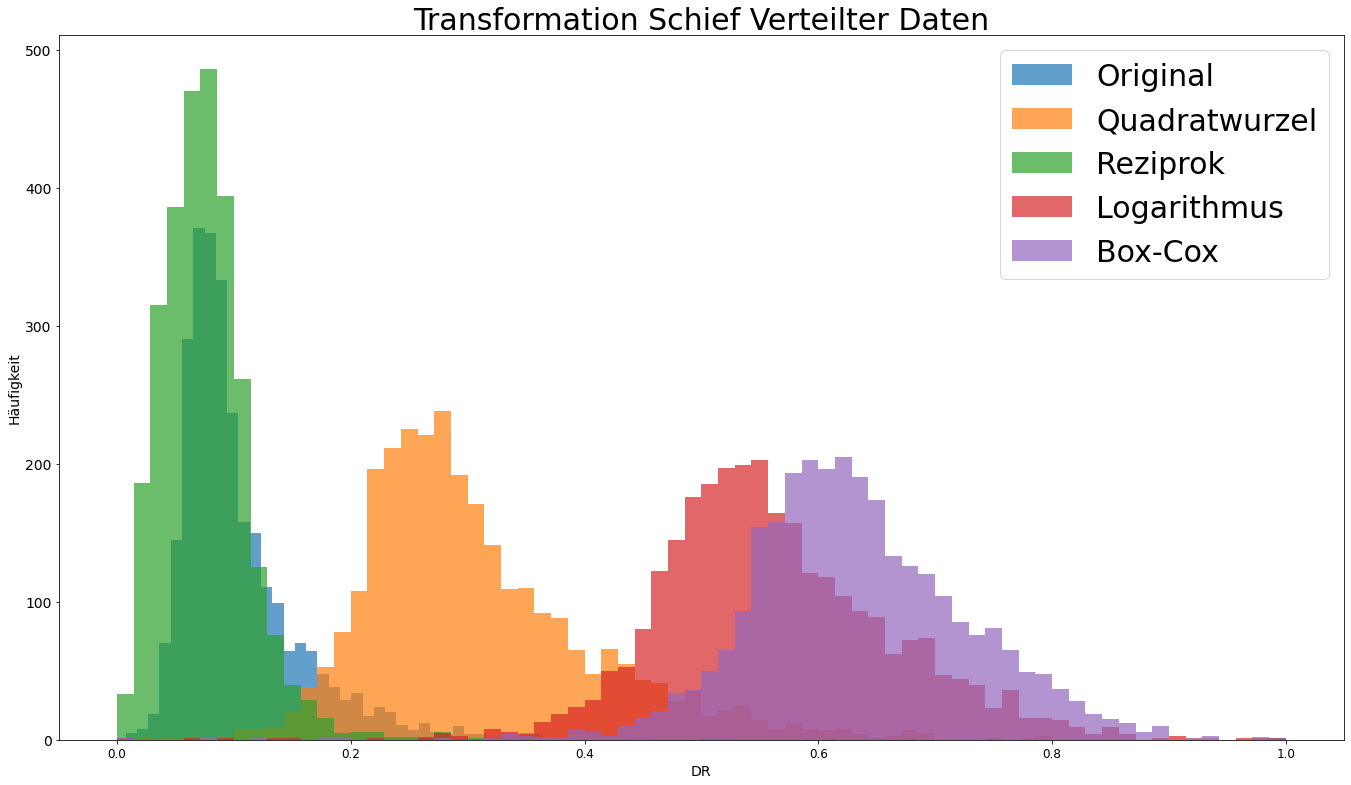

In [0]:
plt.clf()
fig = plt.figure(figsize=(23.04,12.96))

kwards = dict(alpha=0.7, bins=70)

plt.hist(original, **kwards, label='Original')
plt.hist(square, **kwards, label='Quadratwurzel')
plt.hist(rezi, **kwards, label='Reziprok')
plt.hist(log, **kwards, label='Logarithmus')
plt.hist(boxcox, **kwards, label='Box-Cox')

plt.legend(loc='best', fontsize=30)
plt.title('Transformation Schief Verteilter Daten', fontsize=30)
plt.ylabel('Häufigkeit')
plt.xlabel('DR')

plt.show()

Optisch liefert die logarithmische Transformation sowie die Box-Cox Transformation das beste Ergebnis. Schauen wir uns jetzt nochmal die Schiefe mit der `skew()` Methode von Pandas an.

In [0]:
conc_array = np.concatenate(
    (original.reshape(-1,1),
    square.reshape(-1,1),
    rezi.reshape(-1,1),
    log.reshape(-1,1),
    boxcox.reshape(-1,1)),
    axis=1)

(pd.DataFrame(conc_array)).skew(axis=0)

0    2.556145
1    1.289379
2    6.052975
3    0.285622
4   -0.034619
dtype: float64

Die symmetrischste Verteilung ist also durch die Box-Cox Transformation gegeben (minimal linksscheif) gefolgt von der logarithmischen Transformation. <br>

Ist man sich im Vorfeld bewusst, ob die Daten schief sind, können die gewählte Transformation auch in der Pipelines durchgeführt werden.

### Multiple Histogramme in einem Plot

Wie bereits oben gezeigt können mehrere Histogramme in einem Feenster dargestellt werden. Dabei ist der `alpha` Paramter sehr hilfreich um diese transparenter darzustellen.

<Figure size 432x288 with 0 Axes>

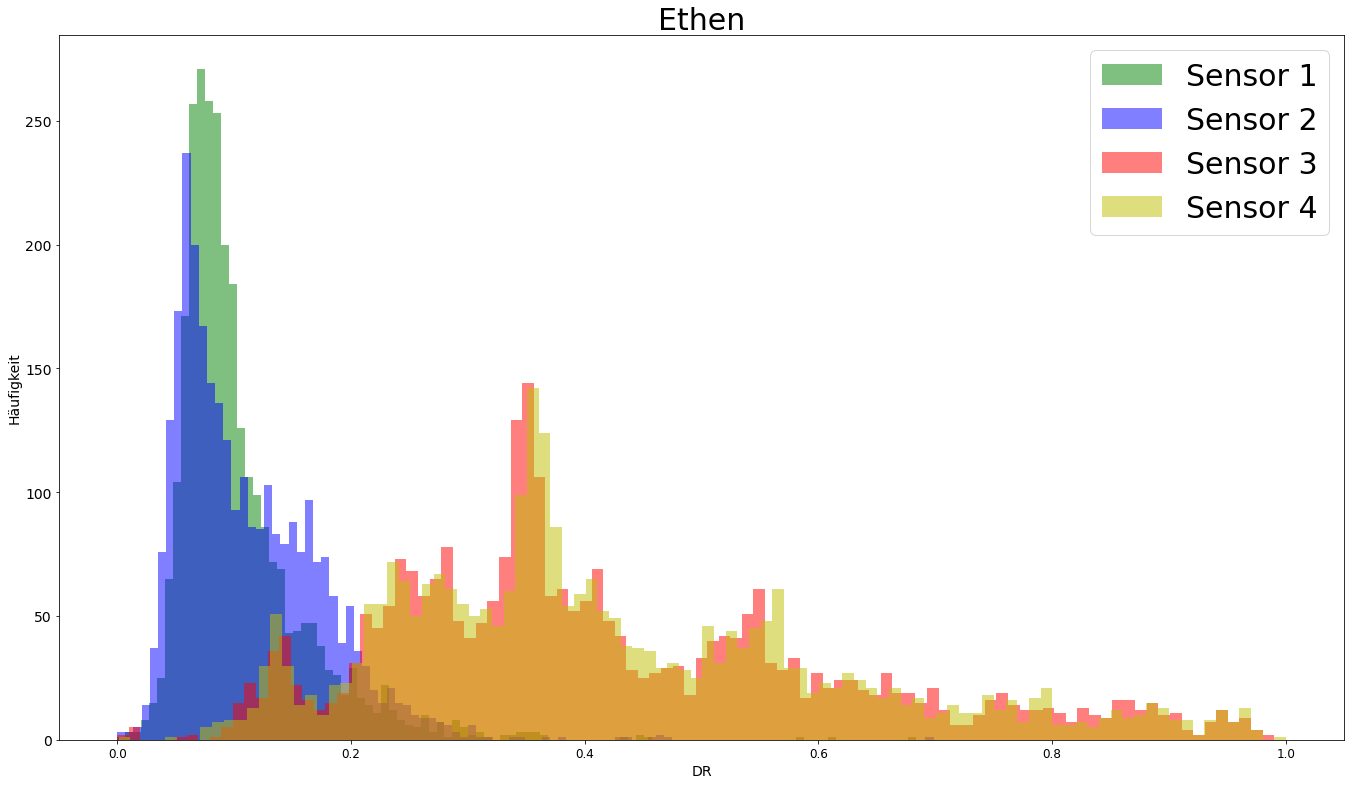

In [0]:
plt.clf()
fig = plt.figure(figsize=(23.04,12.96))

colors = ['g', 'b', 'r', 'y']
kwargs = dict(alpha=0.5, bins=100)
for color in range(len(colors)):
    plt.hist(X_gas[4][:,4+color], **kwargs, color=colors[color], label='Sensor {}'.format(color+1))

plt.title('Ethen', fontsize=30)
plt.ylabel('Häufigkeit')
plt.xlabel('DR')
plt.legend(loc='best', fontsize=30)

plt.show()

Auffällig ist der unterschiedliche Streubereich zwischen den ersten beiden und den letzten beiden Sensoren. Es scheint als würden die ersten beiden Sensoren einer Poisson-Verteilung folgen. Dies ist für die letzten beiden Sensoren nicht ganz so offensichtlich.

### Zweidimensionale Histogramme

2D Histogramme können Beziehungen zwischen verschiedenen Features offenbaren. Darunter zählt das Intensitätsverhältnis, die Korrelation, Clipping, oder auch der Crosstalk. <br>

Dies soll im folgenden Beispiel für das Gas Acetaldehyd für den `DR` Messwert des dritten und vierten Sensors gezeigt werden.

<Figure size 432x288 with 0 Axes>

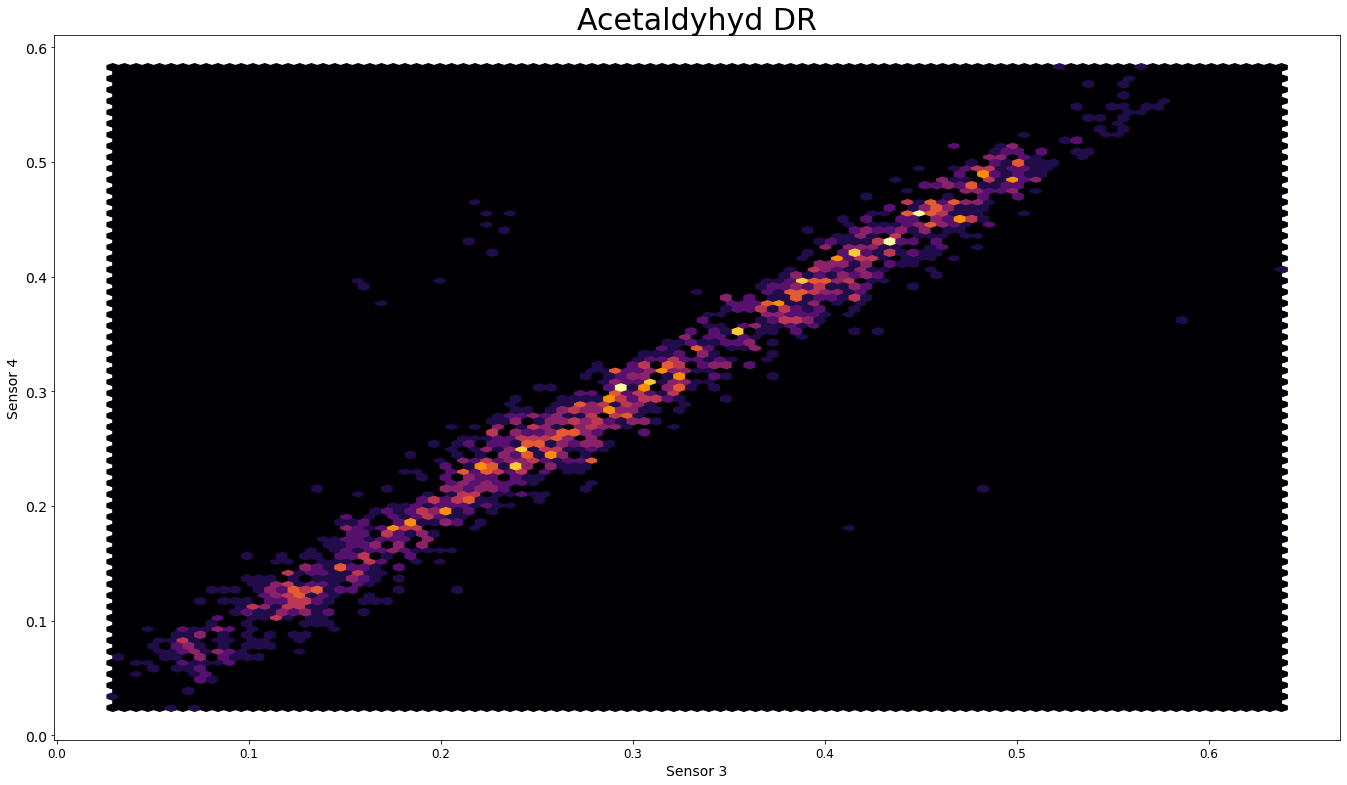

In [0]:
plt.clf()

fig = plt.figure(figsize=(23.04,12.96))

gas = X_gas[0]
plt.hexbin(gas[:,6],gas[:,7], cmap='inferno')

plt.title('Acetaldyhyd DR', fontsize=30)
plt.xlabel('Sensor 3')
plt.ylabel('Sensor 4')

plt.show()

Wir erkennen eine starke Korrelation zwischen diesen beiden Sensoren für das Gas Acetaldhyd. Das Intensitätsmaximum liegt hier bei in etwa 0.3 für beise Sensoren.

### Zeitreihenplot

Schauen wir uns dochmal die Messreihe als Funktion der Konzentrationen (low, medium und high) für das Gas Ethanol an:

<Figure size 432x288 with 0 Axes>

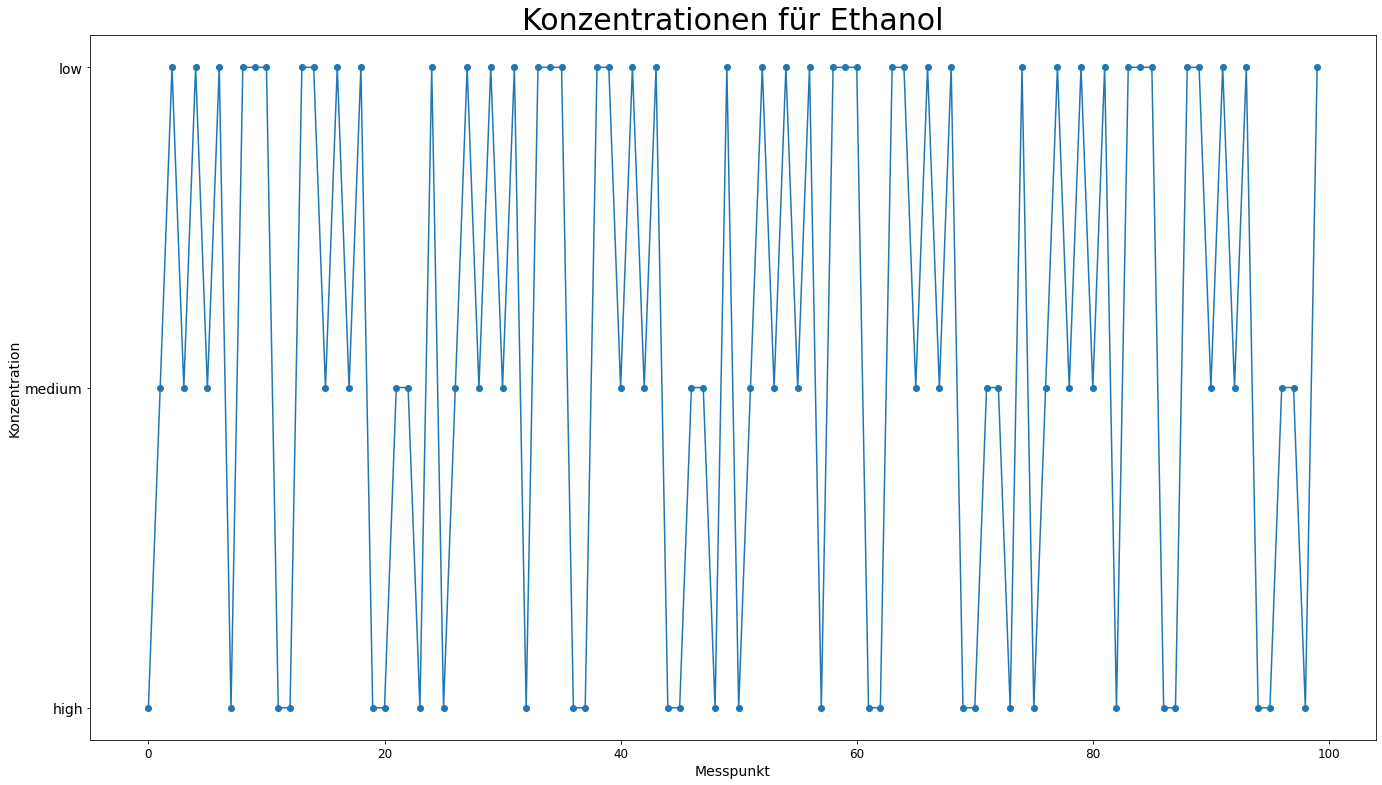

In [0]:
plt.clf()

fig = plt.figure(figsize=(23.04,12.96))

conc_ethanol = np.empty(shape=(X_gas[3].shape[0],)).astype(str)
conc_ethanol[X_gas[3][:,2] == 4] = 'medium'
conc_ethanol[X_gas[3][:,1] == 4] = 'low'
conc_ethanol[X_gas[3][:,3] == 4] = 'high'

plt.plot(conc_ethanol[:100], label='Ethanol', marker='o')

plt.title('Konzentrationen für Ethanol', fontsize=30)
plt.xlabel('Messpunkt')
plt.ylabel('Konzentration')

plt.show()

Das Messverhalten für den gezeigten Bereich ist größtenteils periodisch. <br>

Plotten wir für das selbe Gas die `DR` Messwerte der ersten drei Sensoren.

<Figure size 432x288 with 0 Axes>

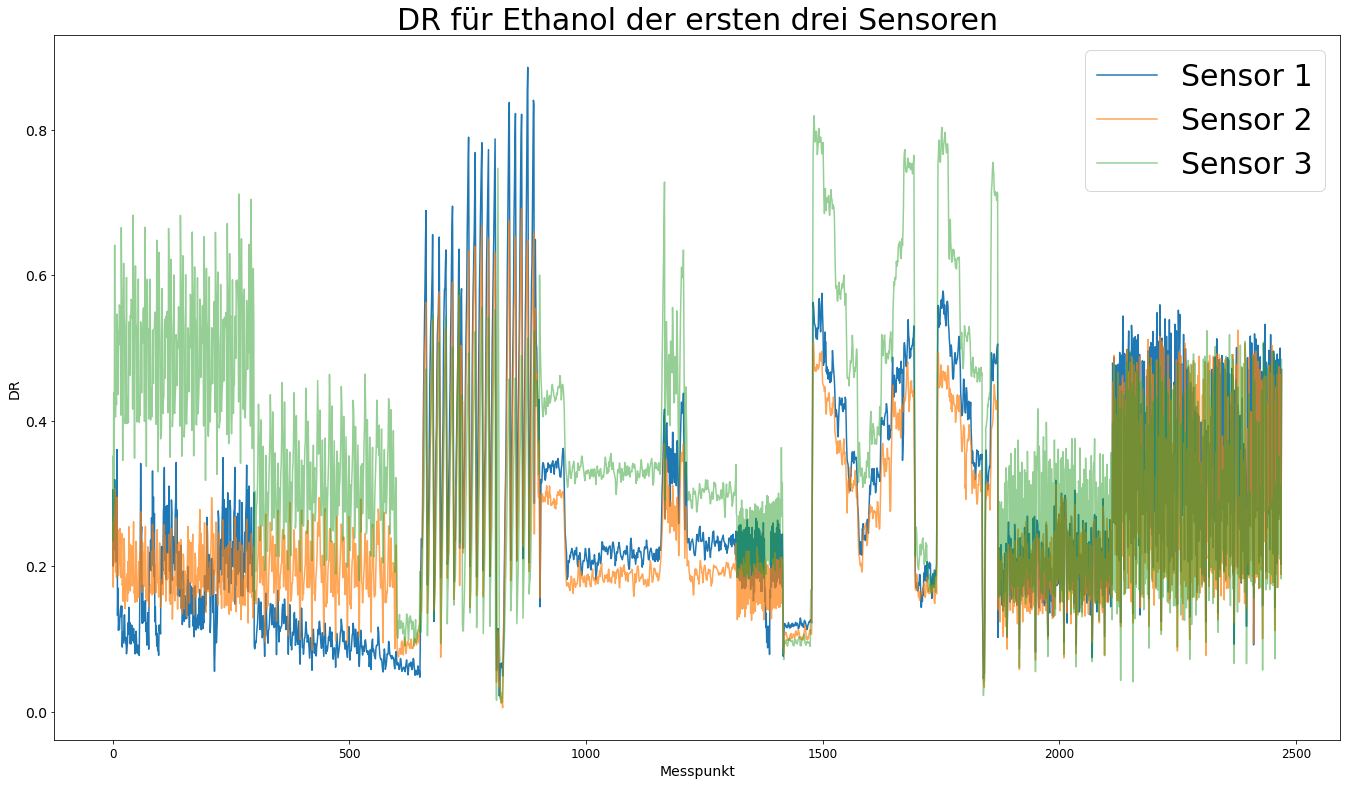

In [0]:
plt.clf()
fig = plt.figure(figsize=(23.04,12.96))

plt.plot(X_gas[3][:,4], alpha=1, label='Sensor 1')
plt.plot(X_gas[3][:,5], alpha=0.7, label='Sensor 2')
plt.plot(X_gas[3][:,6], alpha=0.5, label='Sensor 3')

plt.title('DR für Ethanol der ersten drei Sensoren', fontsize=30)
plt.xlabel('Messpunkt')
plt.ylabel('DR')

plt.legend(loc='best', fontsize=30)

plt.show()

Wir erkennen, dass die `DR` Messwerte unterschiedlicher Sensoren (Sensor 1: Blau, Sensor 2: Orange, Sensor 3: Grün) unterschiedlich stark skalieren, aber ähnliches Verhalten zeigen. Das kann daran liegen, dass die Sensoren von der Bauweise unterschiedlich sind oder von vorangegenagnenen Messungen beeinträchtigt sind. Uns liegen hierzu keinerlei weiteren Informationen darüber vor. Auch kann der experimentelle Aufbau Grund sein für solche starken Abweichungen (keine homogone und/oder isotropische Verteilung des Gases). <br>

Vergleichen wir noch schnell den `DR` Messwert für den ersten Sensor zwischen den Gasen Ethanol, Aceton und Acetaldehyd:

<Figure size 432x288 with 0 Axes>

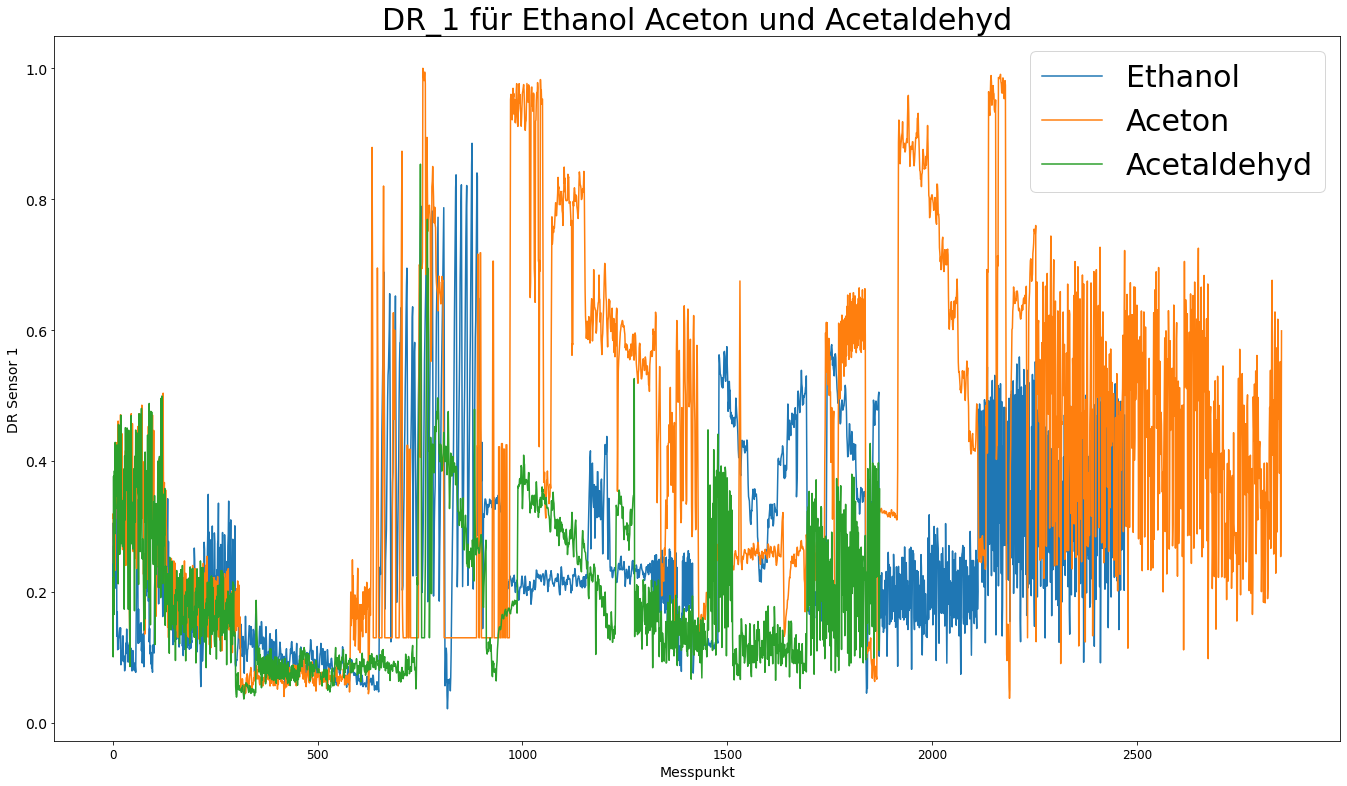

In [0]:
plt.clf()
fig = plt.figure(figsize=(23.04,12.96))

plt.plot(X_gas[3][:,4], alpha=1, label='Ethanol')
plt.plot(X_gas[1][:,4], alpha=1, label='Aceton')
plt.plot(X_gas[0][:,4], alpha=1, label='Acetaldehyd')

plt.title('DR_1 für Ethanol Aceton und Acetaldehyd', fontsize=30)
plt.xlabel('Messpunkt')
plt.ylabel('DR Sensor 1')

plt.legend(loc='best', fontsize=30)

plt.show()

Auch skaliert der `DR` Messert des ersten Sensors in Abhängigkeit der Gase. Bei Aceton ist ein Peak um den Messpunkt ~1250 zu erkennen. Hier kann es sich um lokalen Ausreißer handeln. Die Ausreißerbehandlung die wir weiter oben im Kapitel durchgeführt haben ermittelt ausschließlich globale Ausreißer.

### Visualiere Mittelwerte und Standardabweichungen

Die vier verschiedene `DR` Messwerte können auch gemittelt und visualisiert werden um Trends zu erkennen. Im folgenden soll der Mittelwert und die erste sowie die zweite Standardabweichung von Ethen für die ersten 100 Messwerte berechnet und visualisiert werden.

In [0]:
mean = X_gas[4][:100,4:].mean(axis=1)
std = X_gas[4][:100,4:].std(axis=1)

<Figure size 432x288 with 0 Axes>

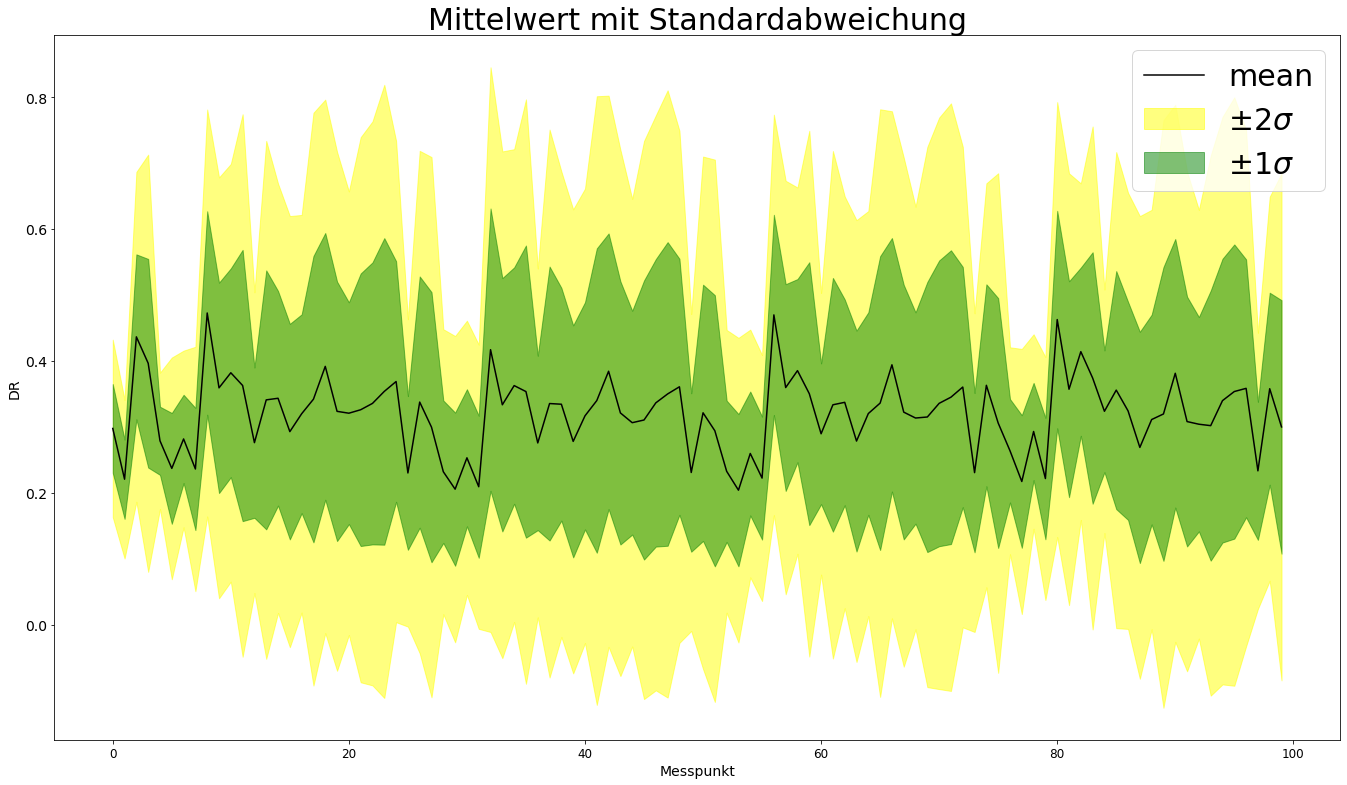

In [0]:
plt.clf()
fig = plt.figure(figsize=(23.04,12.96))

time = np.arange(mean.shape[0])
plt.fill_between(time, mean-2*std, mean+2*std, alpha=0.5, color='yellow', label=r'$\pm 2\sigma$')
plt.fill_between(time, mean-std, mean+std, alpha=0.5, color='green', label=r'$\pm 1\sigma$')
plt.plot(time, mean, color='black', label='mean')

plt.title('Mittelwert mit Standardabweichung', fontsize=30)
plt.xlabel('Messpunkt')
plt.ylabel('DR')
plt.legend(loc='best', fontsize=30)

plt.show()

### Streudiagramme

Als nächstes soll ein Streudiagramm vorgestellt werden. Streudiagramme werden hauptsächlich verwendet für die Darstellung von zwei Variablen. Dabei können auch wie bereits oben im zweidimensionalen Histogramm erläutert Beziehungen zwischen den untersuchten Variablen offenbart werden. <br>

Zunächst plotten wir ein Streudiagramm, welches auf der x-Achse den `DR` Messwert für den ersten Sensor und auf der y-Achse den des dritten Sensor zeigt.

<Figure size 432x288 with 0 Axes>

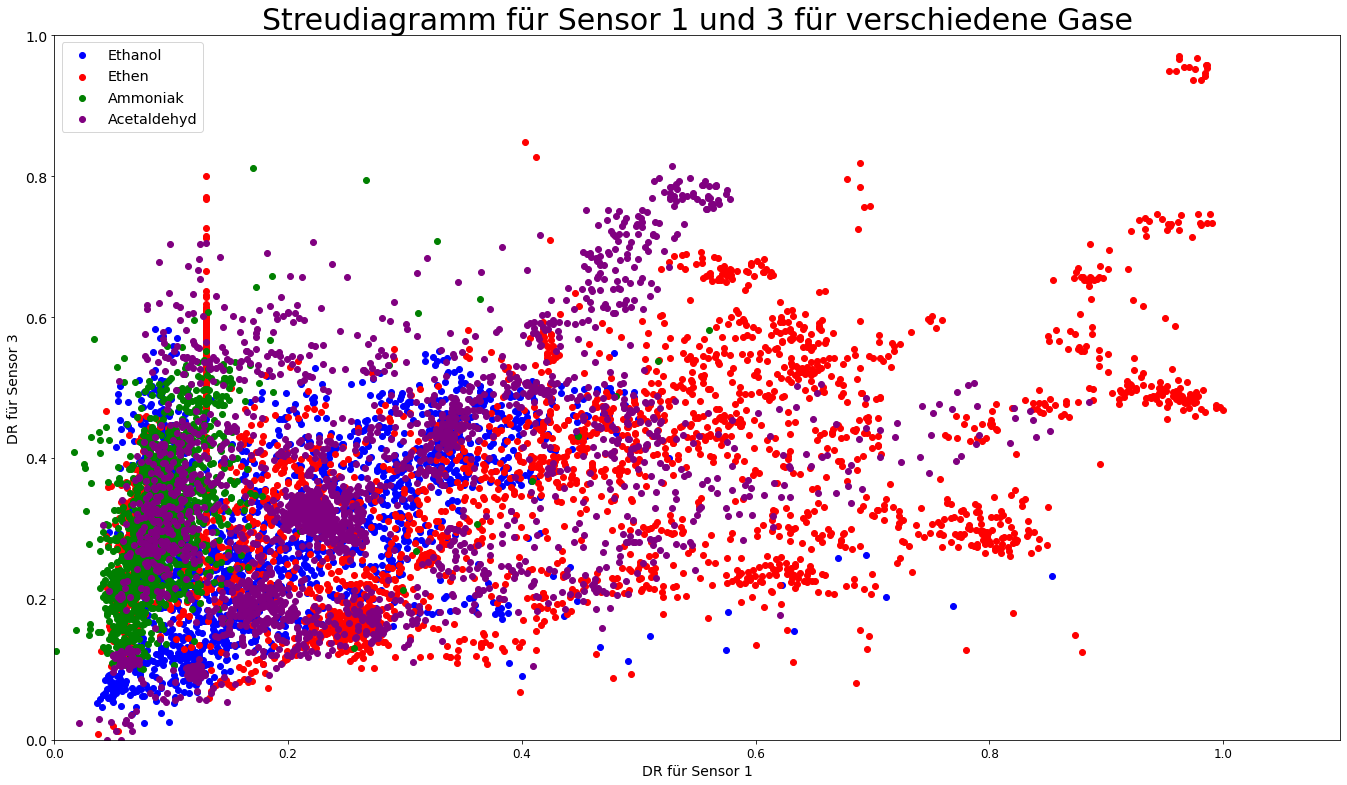

In [0]:
plt.clf()
fig = plt.figure(figsize=(23.04,12.96))

plt.scatter(X_gas[0][:,4], X_gas[0][:,7], label='Ethanol', c='blue')
plt.scatter(X_gas[1][:,4], X_gas[1][:,7], label='Ethen', c='red')
plt.scatter(X_gas[2][:,4], X_gas[2][:,7], label='Ammoniak', c='green')
plt.scatter(X_gas[3][:,4], X_gas[3][:,7], label='Acetaldehyd', c='purple')

plt.xlim(0,1.1)
plt.ylim(0,1)

plt.title('Streudiagramm für Sensor 1 und 3 für verschiedene Gase', fontsize=30)
plt.xlabel('DR für Sensor 1')
plt.ylabel('DR für Sensor 3')
plt.legend(loc='best', fontsize='x-large')


plt.show()

### Streumatrixdiagramm

Eine weitere Möglichkeit um Daten auf ihre Korrelation hin zu überprüfen, ist Pandas `scatter_matrix()` Methode. Diese Methode plottet jedes numerische Feature gegen jedes andere. 

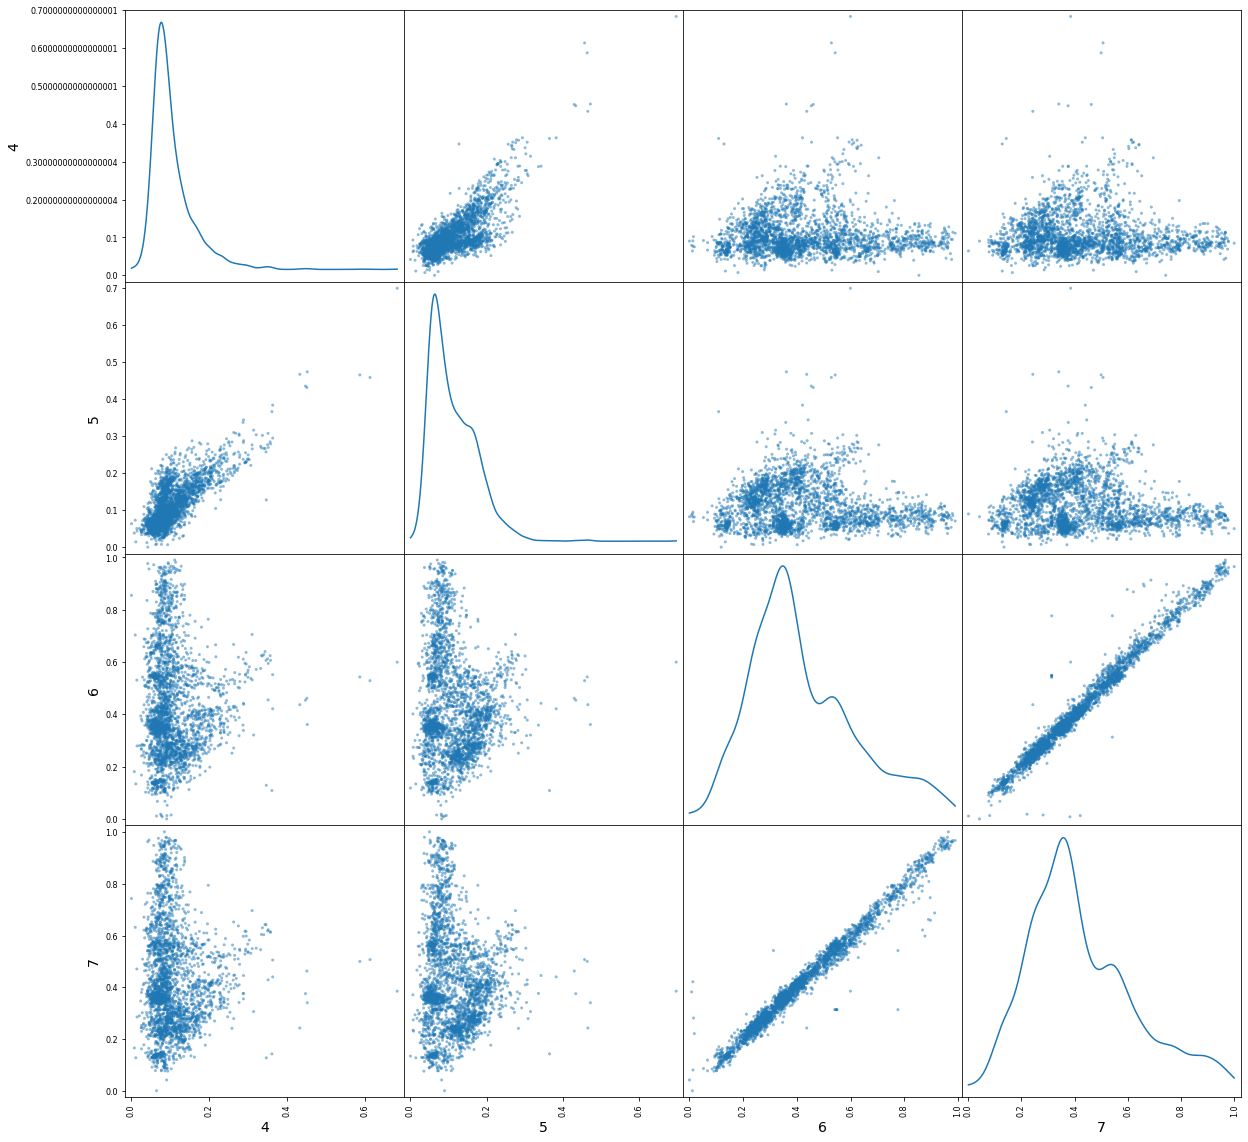

In [0]:
df = pd.DataFrame(X_gas[4])
attributes = [4, 5, 6, 7] # Für die Sensoren eins bis vier
pandas_plot = scatter_matrix(df[attributes], figsize=(20,20), diagonal='kde')

Die diagonalen Plots wären voll mit geraden Linien und daher kann mit dem Paramter `diagonal` zwischen einem Histogramm (`'hist'`, default) oder einer Kerndichteschätzung entschieden werden (`'kde'`). Zwischen dem dritten und vierten Sensor liegt eine starke positive Korrelation vor.

### Boxdiagramme

Als nächstes soll noch ein Boxdiagramm für die sechs verschiedene Gase in Abhängigkeit des `DR` Messwertes für den ersten Sensor gezeigt werden.

In [0]:
data_np = np.c_[np.c_[np_train_prepared[:,0], np_train_prepared[:,2]], np_train_prepared[:,22]]
data_dict = {'DR_1' : data_np[:,0],'DR_3' : data_np[:,1], 'target' : data_np[:,2]}
df = pd.DataFrame(data_dict)

for gas in range(n_gas):
    df['target'][df['target'] == int(gas+1)] = gas_names[gas]

<Figure size 432x288 with 0 Axes>

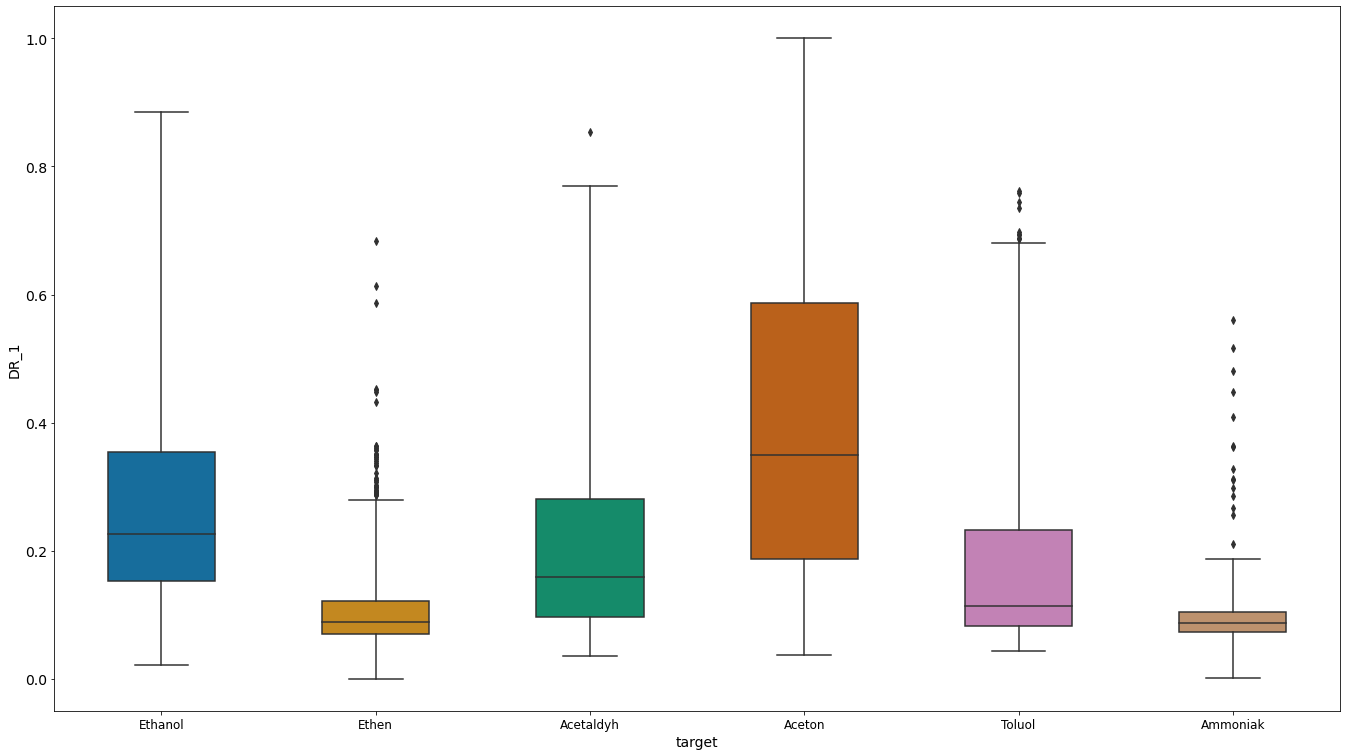

In [0]:
plt.clf()
fig = plt.figure(figsize=(23.04,12.96))

sns.boxplot(x='target', y='DR_1', data=df,  width=0.5, palette='colorblind', fliersize=5, whis=3)

Das Boxdiargramm verät uns die Lage und die Streuung der jeweiligen Verteilungen.  <br>

Das minimale und das maximale Quantil werden durch die Endstriche auch genannt Whiskers dargestellt.
Die Kastenbegrenzungen kennzeichnen das 25% (untere Kastenbegrenzung) und das 75% (obere Kastenbegrenzung) Quantil. Der Strich im Kasten kennzeichnet den Median (50% Quantil). <br>
 
Die Spannweite der Verteilung wird durch das Minimum und das Maximum definiert. Die Länge der Box entspricht dem Interquartilabstand (IQR) in welchem 50% der beobachteten Werte liegen. <br>

Ausreißer sind Werte die mindestens den 3-fachen Abstand des IQR haben und werden als Rauten dargstellt (Ausreißer trotz Ausreißerbehandlung? Das liegt hier an der unterschiedlichen Ausreißererkennung).

### Streudiagramm mit Randhistogrammen

An den Rändern eines Streugiagrams können weitere Diagramme visualisiert werden. Dabei werden auf diese Randdiagrammme die jeweiligen Features des Streudiagramms projeziert. Dies soll im folgenden für den `DR` Messwert des zweiten und dritten Sensors für das Gas Aceton (da dieses Gas über  eine große Streuung verfügt, siehe das Boxdiagrammm oben) für alle drei Konzentrationsstufen gezeigt werden. 

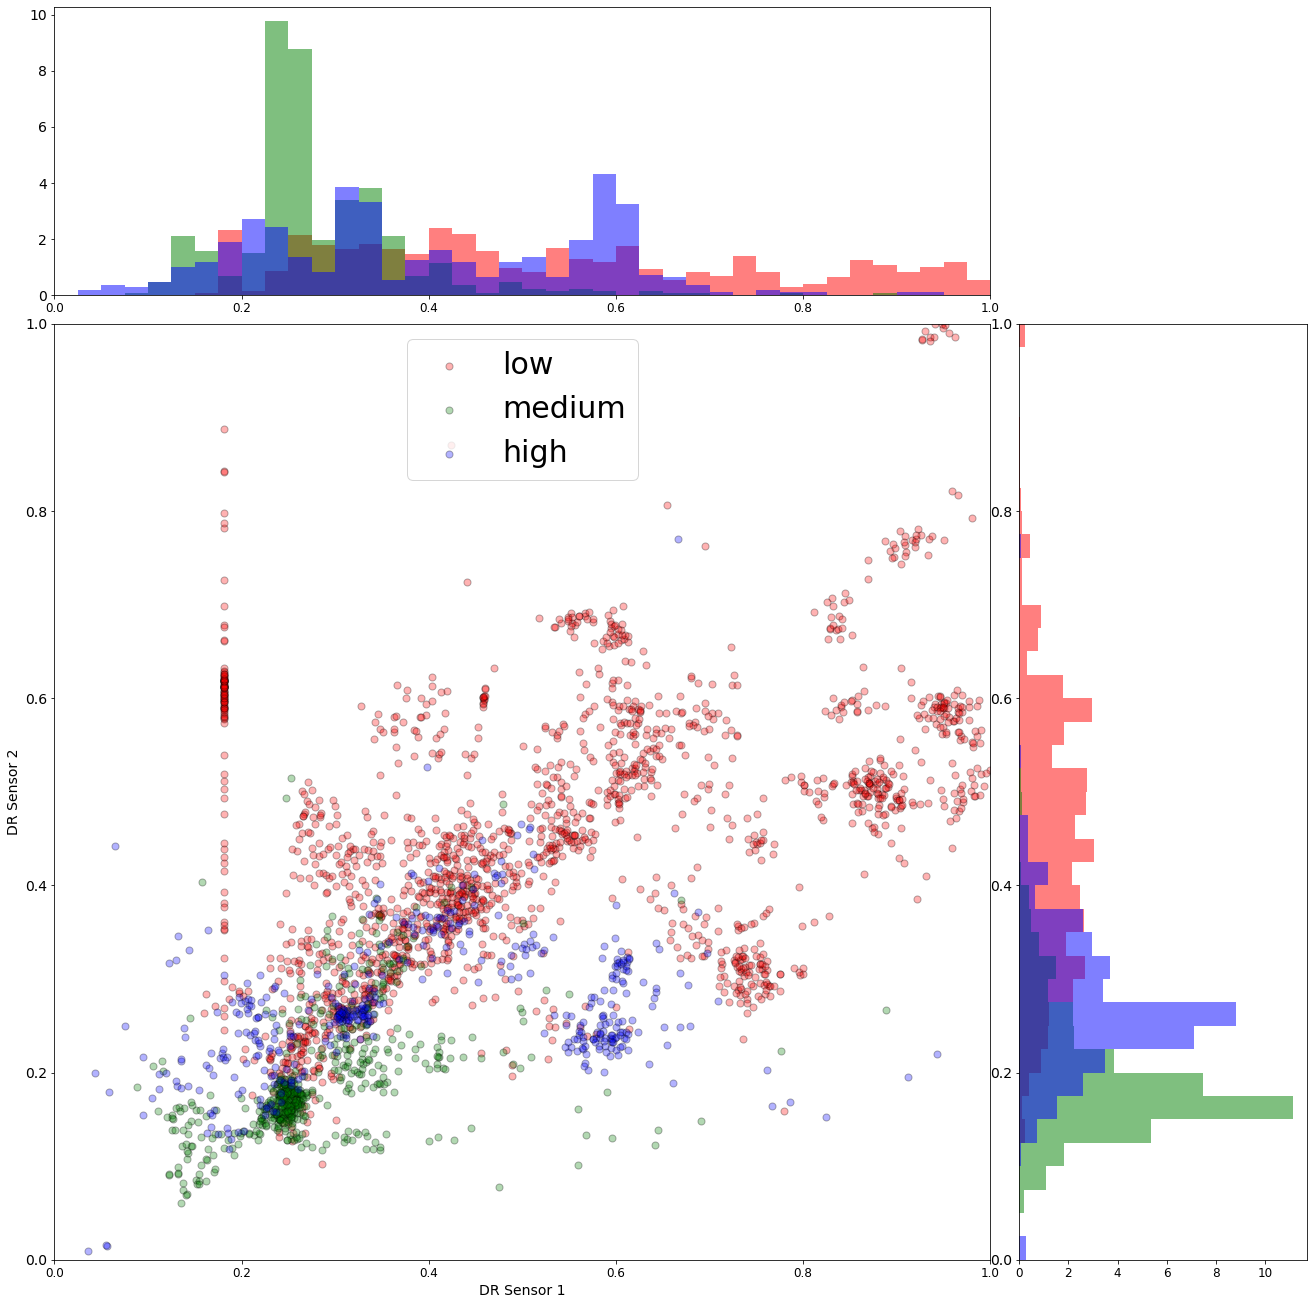

In [0]:
# Definiere Layout
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# Definiere Größe
plt.figure(1, figsize=(20, 20))
axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

label = ['low', 'medium', 'high']
colors = ['r', 'g', 'b']

sensor_2 = [
    X_gas[1][:,5][X_gas[1][:,1] == 2],
    X_gas[1][:,5][X_gas[1][:,2] == 2], 
    X_gas[1][:,5][X_gas[1][:,3] == 2]
]
sensor_3 = [
    X_gas[1][:,6][X_gas[1][:,1] == 2], 
    X_gas[1][:,6][X_gas[1][:,2] == 2], 
    X_gas[1][:,6][X_gas[1][:,3] == 2]
]

# Definiere die Binbreite von Hand
binwidth = 0.025
lim = (int(1/binwidth) + 1) * binwidth
bins = np.arange(-lim, lim + binwidth, binwidth)

kwargs = dict(edgecolors='c', alpha=0.3, edgecolor='k', s=50)
kwargsh = dict(bins=bins, alpha=0.5, density=True)

for color in range(len(colors)):
    axScatter.scatter(sensor_2[color], sensor_3[color],  **kwargs, c=colors[color], label=label[color])
    axHistx.hist(sensor_2[color], **kwargsh, color=colors[color])
    axHisty.hist(sensor_3[color], **kwargsh, color=colors[color], orientation='horizontal')
    
axScatter.set_xlim(.0,1.)
axScatter.set_ylim(.0,1.)
axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axScatter.set_xlabel('DR Sensor 1')
axScatter.set_ylabel('DR Sensor 2')
axScatter.legend(loc='best', fontsize=30)

plt.show()

## Vergleiche Originale und bereinigte Daten

Hier soll lediglich die Ausreißerbehandlung gezeigt werden. Blau zeigt die verunreinigten Daten und Orange die berreinigten Daten. Es ist gut zu erkennen das der Ausreißer um den Messpunkt 4600 erkannt und entfernt wurde. Auch ist die Auswirkung des gleitenden Median zu erkennen.

In [0]:
Image('ausreißer.png')

## Aufgaben

Hier werden noch einige Aufgaben wie zum Beispiel erzeugen einer Heatmap auf Basis der Pearson Korrelation zu erstellen folgen.

Boxplot von einem Gas in den verschiedenen Konzentrationen